# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, GraphPlot
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, SimpleWeightedGraphs, Compose
include("FYON_2022_STG_kinetics.jl") # Loading of DA kinetics of gating variables
include("FYON_2022_STG_models.jl") # Loading of DA model
include("FYON_2022_STG_utils.jl") # Loading of some utils functions
include("FYON_2022_STG_gs_derivatives.jl") # Loading of X_inf derivatives
include("FYON_2022_STG_DIC.jl") # Loading of the DIC and compensation algorithm
include("FYON_2022_STG_neuromodulation.jl"); # Loading of the neuromodulation cells functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 5000
const tspan  = (0.0, Tfinal)

# Definition of reversal potential values (in mV) and membrane capacitance
const C     = 1. # Membrane capacitance
const VNa   = 50 # Sodium reversal potential
const VK    = -80 # Potassium reversal potential
const VCa   = 80 # Calcium reversal potential
const VH    = -20 # HCN channels reversal potential
const Vleak = -50 # Leak reversal potential

# Definition of voltage range for the DICs
const Vmin = -60 
const Vmax = 0
const V    = range(Vmin, stop=Vmax, step=0.01)

# Definition of the number of cells in the random set
const ncells = 200

struct eig
           values
           vectors
       end

default(fmt = :png);

# **Ion current at different voltages**

In [10]:
nb_channels = 8

g_all_MC = readdlm("./data/g_all_MC.dat")
gmeans = mean(g_all_MC, dims=1)

VVmin = -55.
VVmin_str = latexstring("$VVmin")
VVmax = -45.
VVmax_str = latexstring("$VVmax")
V_gv = VVmin : 0.01 : VVmax
Ca_gv = -0.94.*(gmeans[2].*mCaT_inf.(V_gv).^3 .* hCaT_inf.(V_gv).*(V_gv.-VCa) .+ 
                gmeans[3].*mCaS_inf.(V_gv).^3 .* hCaS_inf.(V_gv).*(V_gv.-VCa)) .+ 0.05;

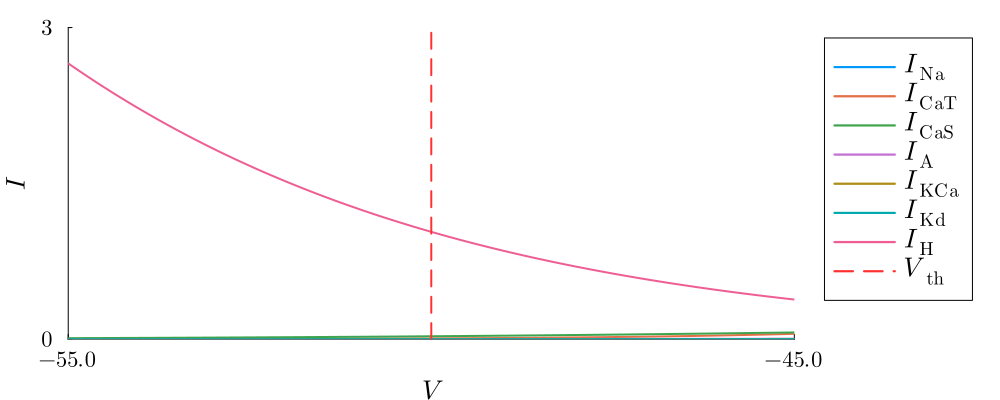

In [12]:
Na_current = abs.(mNa_inf.(V_gv).^3 .* hNa_inf.(V_gv) .* (V_gv.-VNa))
CaT_current = abs.(mCaT_inf.(V_gv).^3 .* hCaT_inf.(V_gv) .* (V_gv.-VCa))
CaS_current = abs.(mCaS_inf.(V_gv).^3 .* hCaS_inf.(V_gv) .* (V_gv.-VCa))
A_current = abs.(mA_inf.(V_gv).^3 .* hA_inf.(V_gv) .* (V_gv.-VK))
KCa_current = abs.(mKCa_inf.(V_gv, Ca_gv).^4 .* (V_gv.-VK))
Kd_current = abs.(mKd_inf.(V_gv).^4 .* (V_gv.-VK))
H_current = abs.(mH_inf.(V_gv) .* (V_gv.-VH))
y_max = max(maximum(Na_current), maximum(CaT_current), maximum(CaS_current), 
            maximum(A_current), maximum(KCa_current), maximum(Kd_current), maximum(H_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(CaT_current), minimum(CaS_current), 
            minimum(A_current), minimum(KCa_current), minimum(Kd_current), minimum(H_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=2, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, CaT_current, label=L"I_\mathrm{CaT}", linewidth=2)
plot!(V_gv, CaS_current, label=L"I_\mathrm{CaS}", linewidth=2)
plot!(V_gv, A_current, label=L"I_\mathrm{A}", linewidth=2)
plot!(V_gv, KCa_current, label=L"I_\mathrm{KCa}", linewidth=2)
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=2)
plot!(V_gv, H_current, label=L"I_\mathrm{H}", linewidth=2)
vline!([-50.], linewidth=2, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"I")
# savefig(p0, "STG_current_nog.pdf")

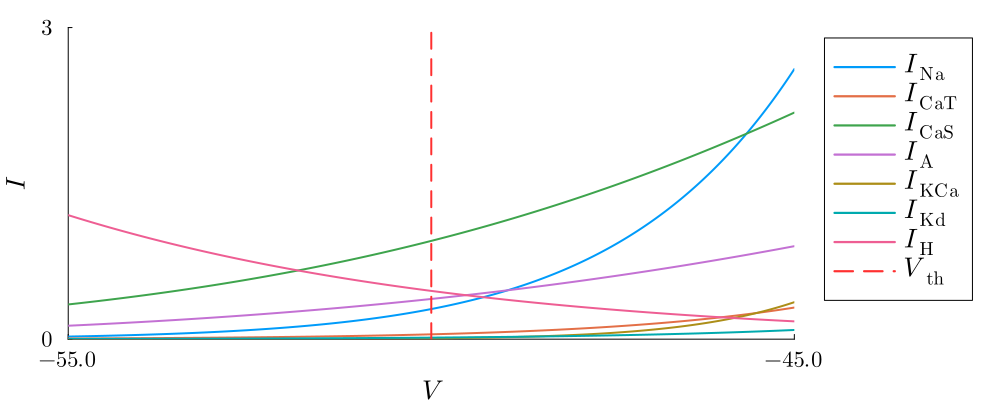

In [13]:
Na_current = abs.(gmeans[1]*mNa_inf.(V_gv).^3 .* hNa_inf.(V_gv) .* (V_gv.-VNa))
CaT_current = abs.(gmeans[2]*mCaT_inf.(V_gv).^3 .* hCaT_inf.(V_gv) .* (V_gv.-VCa))
CaS_current = abs.(gmeans[3]*mCaS_inf.(V_gv).^3 .* hCaS_inf.(V_gv) .* (V_gv.-VCa))
A_current = abs.(gmeans[4]*mA_inf.(V_gv).^3 .* hA_inf.(V_gv) .* (V_gv.-VK))
KCa_current = abs.(gmeans[5]*mKCa_inf.(V_gv, Ca_gv).^4 .* (V_gv.-VK))
Kd_current = abs.(gmeans[6]*mKd_inf.(V_gv).^4 .* (V_gv.-VK))
H_current = abs.(gmeans[7]*mH_inf.(V_gv) .* (V_gv.-VH))
y_max = max(maximum(Na_current), maximum(CaT_current), maximum(CaS_current), 
            maximum(A_current), maximum(KCa_current), maximum(Kd_current), maximum(H_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(CaT_current), minimum(CaS_current), 
            minimum(A_current), minimum(KCa_current), minimum(Kd_current), minimum(H_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=2, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, CaT_current, label=L"I_\mathrm{CaT}", linewidth=2)
plot!(V_gv, CaS_current, label=L"I_\mathrm{CaS}", linewidth=2)
plot!(V_gv, A_current, label=L"I_\mathrm{A}", linewidth=2)
plot!(V_gv, KCa_current, label=L"I_\mathrm{KCa}", linewidth=2)
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=2)
plot!(V_gv, H_current, label=L"I_\mathrm{H}", linewidth=2)
vline!([-50.], linewidth=2, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"I")
# savefig(p0, "STG_current.pdf")

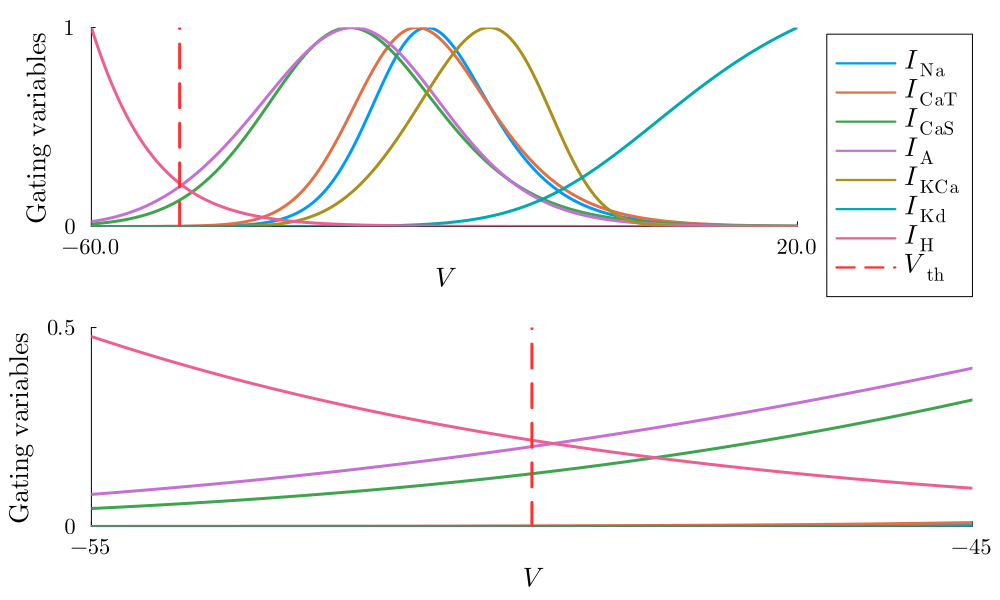

In [31]:
VVmin = -60.
VVmin_str = latexstring("$VVmin")
VVmax = 20.
VVmax_str = latexstring("$VVmax")
V_gv = VVmin : 0.01 : VVmax
Ca_gv = -0.94.*(gmeans[2].*mCaT_inf.(V_gv).^3 .* hCaT_inf.(V_gv).*(V_gv.-VCa) .+ 
                gmeans[3].*mCaS_inf.(V_gv).^3 .* hCaS_inf.(V_gv).*(V_gv.-VCa)) .+ 0.05
Na_current = mNa_inf.(V_gv).^3 .* hNa_inf.(V_gv)
Na_current = Na_current / maximum(Na_current)
CaT_current = mCaT_inf.(V_gv).^3 .* hCaT_inf.(V_gv)
CaT_current = CaT_current / maximum(CaT_current)
CaS_current = mCaS_inf.(V_gv).^3 .* hCaS_inf.(V_gv)
CaS_current = CaS_current / maximum(CaS_current)
A_current = mA_inf.(V_gv).^3 .* hA_inf.(V_gv)
A_current = A_current / maximum(A_current)
KCa_current = mKCa_inf.(V_gv, Ca_gv).^4
KCa_current = KCa_current / maximum(KCa_current)
Kd_current = mKd_inf.(V_gv).^4
Kd_current = Kd_current / maximum(Kd_current)
H_current = mH_inf.(V_gv)
H_current = H_current / maximum(H_current)
y_max = max(maximum(Na_current), maximum(CaT_current), maximum(CaS_current), 
            maximum(A_current), maximum(KCa_current), maximum(Kd_current), maximum(H_current))
y_max = Int(round(y_max, RoundUp))
y_max_str = latexstring("$y_max")
y_min = min(minimum(Na_current), minimum(CaT_current), minimum(CaS_current), 
            minimum(A_current), minimum(KCa_current), minimum(Kd_current), minimum(H_current))
y_min = Int(round(y_min, RoundDown))
y_min_str = latexstring("$y_min")

p0 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([VVmin, VVmax], [VVmin_str, VVmax_str]), 
    yticks=([y_min, y_max], [y_min_str, y_max_str]), linewidth=3, tickfontsize=15, 
    size=(1000, 400), legend=:outertopright, xlims=(VVmin, VVmax), ylims=(y_min, y_max))
plot!(V_gv, CaT_current, label=L"I_\mathrm{CaT}", linewidth=3)
plot!(V_gv, CaS_current, label=L"I_\mathrm{CaS}", linewidth=3)
plot!(V_gv, A_current, label=L"I_\mathrm{A}", linewidth=3)
plot!(V_gv, KCa_current, label=L"I_\mathrm{KCa}", linewidth=3)
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=3)
plot!(V_gv, H_current, label=L"I_\mathrm{H}", linewidth=3)
vline!([-50.], linewidth=3, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"\mathrm{Gating}\,\, \mathrm{variables}")

p1 = plot(V_gv, Na_current, grid=false, label=L"I_\mathrm{Na}", guidefontsize=18, legendfontsize=18, 
    margin=5Plots.mm, xticks=([-55., -45.], [L"-55", L"-45"]), 
    yticks=([y_min, 0.5], [y_min_str, L"0.5"]), linewidth=3, tickfontsize=15, 
    size=(1000, 400), legend=false, xlims=(-55., -45.), ylims=(y_min, 0.5))
plot!(V_gv, CaT_current, label=L"I_\mathrm{CaT}", linewidth=3)
plot!(V_gv, CaS_current, label=L"I_\mathrm{CaS}", linewidth=3)
plot!(V_gv, A_current, label=L"I_\mathrm{A}", linewidth=3)
plot!(V_gv, KCa_current, label=L"I_\mathrm{KCa}", linewidth=3)
plot!(V_gv, Kd_current, label=L"I_\mathrm{Kd}", linewidth=3)
plot!(V_gv, H_current, label=L"I_\mathrm{H}", linewidth=3)
vline!([-50.], linewidth=3, color=:firebrick1, linestyle=:dash, label=L"V_\mathrm{th}")
xlabel!(L"V")
ylabel!(L"\mathrm{Gating}\,\, \mathrm{variables}")
CC = plot(p0, p1, layout=(2, 1), size=(1000, 600))
# savefig(p0, "STG_current_zoomed.pdf")

# **Computing PCA of high frequency bursting neurons and homogeneous scaling using Monte Carlo (Figure 1)**

In [6]:
# Initializing some variables
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02
N = 7e4
VV_maxmax = 49.95
VV_maxmin = 49.9
VV_minmax = -69.
VV_minmin = -76.
nb_spikes_target = 5
burstiness_min = 3000.
burstiness_max = 7000.
interburst_f_min = 8.8
interburst_f_max = 9.9
intraburst_f_max = 140.
intraburst_f_min = 70.
nb_channels = 8

g_all_MC = readdlm("./data/g_all_MC.dat");

# **New figure 1**

In [7]:
names = [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
         L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
         L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]
maxs = [Na_max, CaT_max, CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max];

3×3 Matrix{Float64}:
  0.590312   NaN         NaN
 -0.0500555   -0.383654  NaN
  0.608978     0.293368    0.0114151

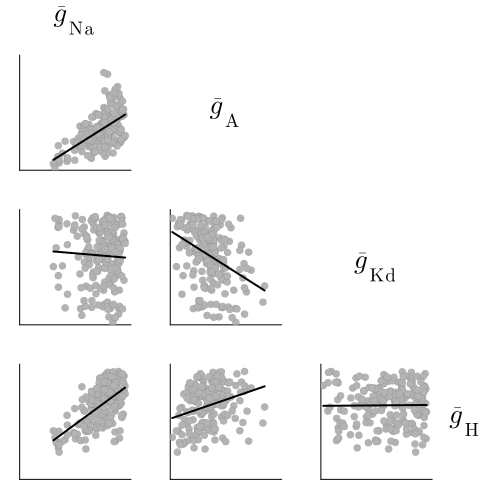

In [5]:
indices = [1, 4, 6, 7]
CC = scatter_matrix3x3(g_all_MC[:, indices], maxs[indices], :gray70, :none, names[indices], flag=0)
display(CC)
# savefig(CC, "./figures/STG_MC_matrix3x3_corr.pdf")

In [6]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_MC[:, i1], g_all_MC[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end

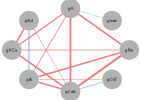

In [7]:
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gCaT", "gCaS", "gA", "gKCa", "gKd", "gH", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/STG_graph_corr.svg", 16cm, 10cm), gdraw);

# **New figure 2**

In [8]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC[:, i] / std(g_all_MC[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] * std(g_all_MC[:, i])
end

In [9]:
Random.seed!(2022)
N = 2000
eig_val_MC_shuffle = zeros(nb_channels, N)
eig_val_decreasing_shuffle = zeros(nb_channels, N)
for j = 1 : N
    g_all_MC_shuffle = zero(g_all_MC)
    for i = 1 : nb_channels
        g_all_MC_shuffle[:, i] = shuffle(g_all_MC[:, i])
    end

    # Normalizing data before applying PCA
    g_all_MC_shuffle_norm = deepcopy(g_all_MC_shuffle)
    for i = 1 : nb_channels
        g_all_MC_shuffle_norm[:, i] = g_all_MC_shuffle[:, i] / std(g_all_MC_shuffle[:, i])
    end

    # PCA on spiking point cloud
    cov_matrix_MC_shuffle = cov(g_all_MC_shuffle_norm)
    eig_MC_shuffle = eigen(cov_matrix_MC_shuffle, sortby = x -> abs(x))
    eig_val_MC_shuffle[:, j] = eig_MC_shuffle.values
    
    total_var_shuffle = sum(eig_val_MC_shuffle[:, j])
    eig_val_decreasing_shuffle[:, j] = reverse(eig_val_MC_shuffle[:, j]) ./ total_var_shuffle
end

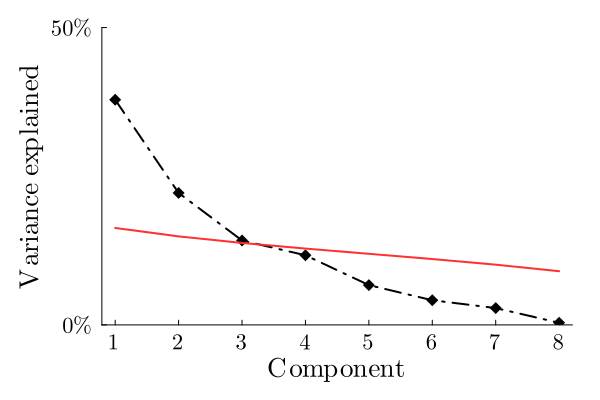

In [10]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values) ./ total_var

p1a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 0.5], [L"0\%", L"50\%"]), size=(600, 400))

plot!(mean(eig_val_decreasing_shuffle, dims=2), label="", grid=false,
      linestyle=:solid, color=:firebrick1, markersize=6, linewidth=2)
ylims!((0., 0.5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p1a)
# savefig(p1a, "./figures/STG_MC_scree_shuffle.pdf")

In [11]:
important_PCA = 0
eig_val_decreasing = reverse(eig_MC.values)
eig_val_decreasing_shuffle = reverse(mean(eig_val_MC_shuffle, dims=2))
while(eig_val_decreasing[important_PCA+1] > eig_val_decreasing_shuffle[important_PCA+1])
    important_PCA = important_PCA + 1
end
display(important_PCA)

3

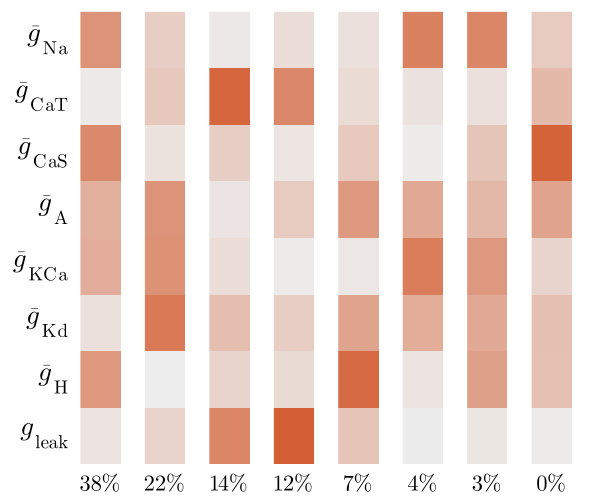

In [12]:
CC = heatmap_dir(eig_MC, nb_channels)
display(CC)
# savefig(CC, "./figures/STG_MC_eig_vectors.pdf")

# **New figure 3**

In [13]:
PC1_abs = abs.(eig_MC.vectors[:, nb_channels]) ./ 
        norm(eig_MC.vectors[:, nb_channels])
best_four = sortperm(PC1_abs, rev=true)[1:4];

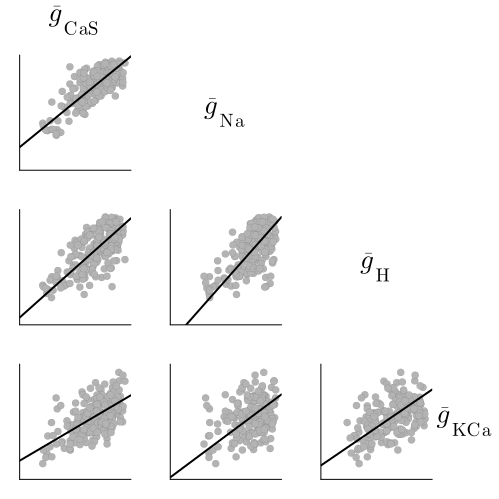

In [14]:
dir_val = eig(eig_MC_plot.values[end],  eig_MC_plot.vectors[best_four, :])
CC = scatter_matrix3x3(g_all_MC[:, best_four], maxs[best_four], :gray70, :none, names[best_four], 
                  flag=1, dir_val=dir_val, mean_vec=mean_MC[best_four], s1=1000)
display(CC)
# savefig(CC, "./figures/STG_MC_matrix3x3_PC1.pdf")

In [15]:
function gram_schmidt(A)
    m, n = size(A)
    Q = similar(A)
    R = zeros(n, n)
    for j = 1 : n
        v = A[:, j]
        for i = 1 : j-1
            R[i, j] = dot(Q[:, i], A[:, j])
            v -= R[i, j] * Q[:, i]
        end
        R[j, j] = norm(v)
        Q[:, j] = v / R[j, j]
    end
    return Q, R
end;

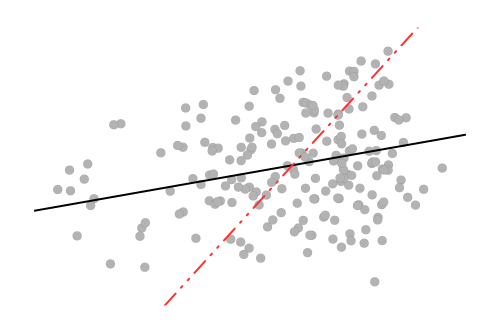

In [16]:
PC1 = -eig_MC.vectors[:, nb_channels]
homo_scaling = deepcopy(vec(mean_MC))
for i = 1 : nb_channels
    homo_scaling[i] = homo_scaling[i] / std(g_all_MC[:, i])
end
base = zeros(nb_channels, 2)
base[:, 1] = PC1
base[:, 2] = homo_scaling ./ norm(homo_scaling)
rotation_angle = -10
R = [cosd(rotation_angle) -sind(rotation_angle); sind(rotation_angle) cosd(rotation_angle)]

Q, _ = gram_schmidt(base)
Q = Q *R

g_all_MC_Qbase = g_all_MC_norm * Q

p = scatter(g_all_MC_Qbase[:, 1], g_all_MC_Qbase[:, 2], label="", color=:gray70, grid=false,
        yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, axis=false,
        markerstrokewidth=0., markersize=5, ticks=false, aspect_ratio=:equal, size=(500, 333))
mean_g_all_MC_Qbase = mean(g_all_MC_Qbase, dims=1)
points = zeros(2, nb_channels)
s = 50
points[1, :] = -PC1*s
points[2, :] = PC1*s
points = points * Q
plot!(points[:, 1] .+ mean_g_all_MC_Qbase[1], points[:, 2] .+ mean_g_all_MC_Qbase[2],
      arrow=false, color=:black, linewidth=2, label="", linestyle=:solid)

points = zeros(2, nb_channels)
points[1, :] = -homo_scaling*s
points[2, :] = homo_scaling*s
points = points * Q
plot!(points[:, 1] .+ mean_g_all_MC_Qbase[1], points[:, 2] .+ mean_g_all_MC_Qbase[2],
      arrow=false, color=:firebrick1, linewidth=2, label="", linestyle=:dashdotdot)

xlims!((minimum(g_all_MC_Qbase[:, 1])-0.5, maximum(g_all_MC_Qbase[:, 1])+0.5))
ylims!((minimum(g_all_MC_Qbase[:, 2])-0.5, maximum(g_all_MC_Qbase[:, 2])+0.5))
# xlabel!(L"\mathrm{PC}1")
# ylabel!(L"\mathrm{Homogeneous}\,\,\mathrm{scaling}")
display(p)
# savefig(p, "./figures/STG_MC_PC1_homo.pdf")

In [17]:
function angle_between_vectors(u, v)
    dot_prod = dot(u, v)
    norm_u = norm(u)
    norm_v = norm(v)
    angle = acosd(dot_prod / (norm_u * norm_v))
    return angle
end

display(angle_between_vectors(PC1, homo_scaling))
display(cosd(angle_between_vectors(PC1, homo_scaling)))

37.69493741812092

0.7912775636267837

# **New figure 4**

In [18]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_doublets = readdlm("./data/g_all_doublets.dat")
g_all_doublets_DIC = readdlm("./data/g_all_doublets_DIC.dat")
g_all_doublets_leak = readdlm("./data/g_all_doublets_leak.dat")

g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat");

In [19]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting)

# Normalizing data before applying PCA
g_all_bursting_norm = deepcopy(g_all_bursting)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting[:, i] / std(g_all_bursting[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] * std(g_all_bursting[:, i])
end

In [20]:
Random.seed!(2022)
N = 2000
eig_val_bursting_shuffle = zeros(nb_channels, N)
eig_val_decreasing_shuffle = zeros(nb_channels, N)
for j = 1 : N
    g_all_bursting_shuffle = zero(g_all_bursting)
    for i = 1 : nb_channels
        g_all_bursting_shuffle[:, i] = shuffle(g_all_bursting[:, i])
    end

    # Normalizing data before applying PCA
    g_all_bursting_shuffle_norm = deepcopy(g_all_bursting_shuffle)
    for i = 1 : nb_channels
        g_all_bursting_shuffle_norm[:, i] = g_all_bursting_shuffle[:, i] / std(g_all_bursting_shuffle[:, i])
    end

    # PCA on spiking point cloud
    cov_matrix_bursting_shuffle = cov(g_all_bursting_shuffle_norm)
    eig_bursting_shuffle = eigen(cov_matrix_bursting_shuffle, sortby = x -> abs(x))
    eig_val_bursting_shuffle[:, j] = eig_bursting_shuffle.values
    
    total_var_shuffle = sum(eig_val_bursting_shuffle[:, j])
    eig_val_decreasing_shuffle[:, j] = reverse(eig_val_bursting_shuffle[:, j]) ./ total_var_shuffle
end

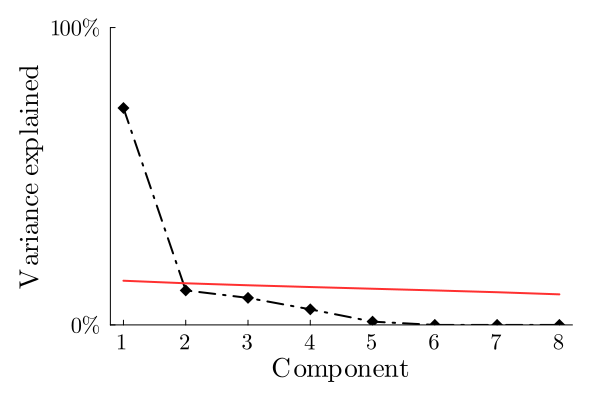

In [21]:
total_var = sum(eig_bursting.values)
eig_val_decreasing = reverse(eig_bursting.values) ./ total_var

p1a  = plot(eig_val_decreasing, label="", grid=false, guidefontsize=18, markershape=:diamond, 
            linestyle=:dashdot, legendfontsize=12, margin=5Plots.mm, 
            xticks=([1, 2, 3, 4, 5, 6, 7, 8], [L"1", L"2", L"3", L"4", L"5", L"6", L"7", L"8"]), 
            color=:black, markersize=6, linewidth=2, tickfontsize=15,
            yticks=([0, 1.], [L"0\%", L"100\%"]), size=(600, 400))

plot!(mean(eig_val_decreasing_shuffle, dims=2), label="", grid=false,
      linestyle=:solid, color=:firebrick1, markersize=6, linewidth=2)

ylims!((0., 1.))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Variance}\,\,\mathrm{explained}")
display(p1a)
# savefig(p1a, "./figures/STG_bursting_scree_shuffle.pdf")

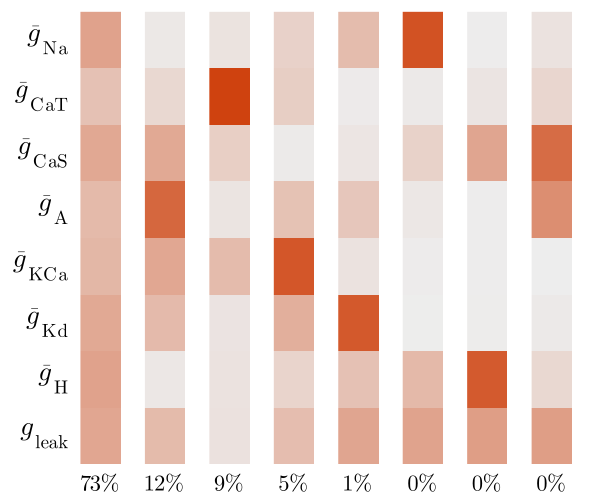

In [22]:
CC = heatmap_dir(eig_bursting, nb_channels)
display(CC)
# savefig(CC, "./figures/STG_bursting_eig_vectors.pdf")

In [23]:
PC2_abs = abs.(eig_bursting.vectors[:, nb_channels-1]) ./ 
        norm(eig_bursting.vectors[:, nb_channels-1])
best_four = sortperm(PC2_abs, rev=true)[1:4];
best_four = [1, 4, 3, 7];

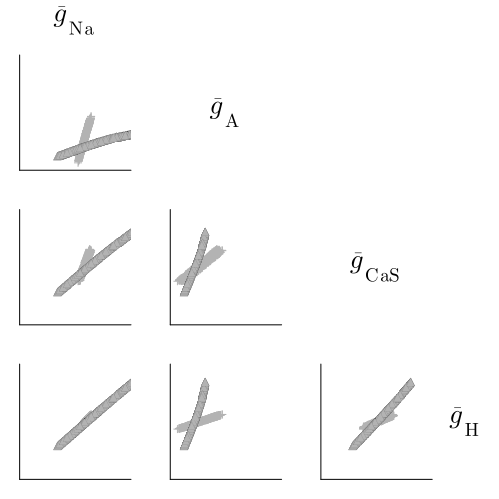

In [24]:
CC = scatter_matrix3x3(g_all_bursting_DIC[:, best_four], maxs[best_four], :gray70, :cross, 
                       names[best_four], flag=3, flag2=1, g_all2=g_all_bursting_leak[:, best_four], 
                       m_shape2=:utriangle)
display(CC)
# savefig(CC, "./figures/STG_bursting_matrix3x3_separated.pdf")

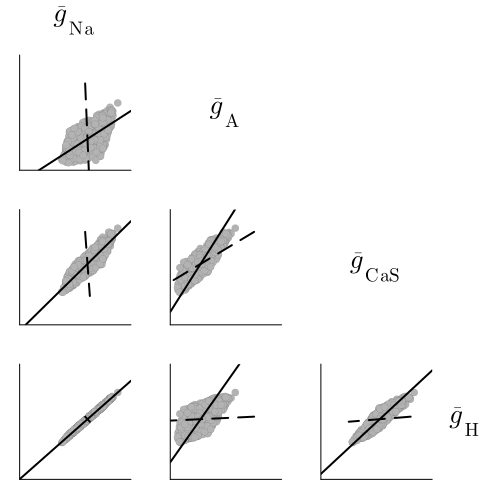

In [25]:
dir_val = eig(eig_bursting_plot.values[end],  eig_bursting_plot.vectors[best_four, :])
CC = scatter_matrix3x3(g_all_bursting[:, best_four], maxs[best_four], :gray70, :none, names[best_four], 
                       flag=2, dir_val=dir_val, mean_vec=mean_bursting[best_four], s1=10, s2=1)
display(CC)
# savefig(CC, "./figures/STG_bursting_matrix3x3_PC12.pdf")

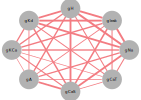

In [26]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_bursting[:, i1], g_all_bursting[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gCaT", "gCaS", "gA", "gKCa", "gKd", "gH", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/STG_graph_corr_bursting.svg", 16cm, 10cm), gdraw);

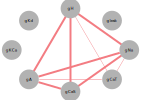

In [27]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_bursting_DIC[:, i1], g_all_bursting_DIC[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gCaT", "gCaS", "gA", "gKCa", "gKd", "gH", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/STG_graph_corr_bursting_DIC.svg", 16cm, 10cm), gdraw);

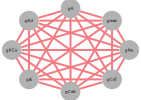

In [28]:
nb_edges = Int(nb_channels * (nb_channels-1) / 2)
r_values = zeros(nb_edges)
i1 = 1
i2 = 2
for i = 1 : nb_edges
    r_values[i] = cor(g_all_bursting_leak[:, i1], g_all_bursting_leak[:, i2])
    if abs(r_values[i]) < 1/nb_channels
        r_values[i] = 0.0
    end
    if i2 == i1 + 1
        i1 = 1
        i2 = i2 + 1
    else
        i1 = i1 + 1
    end
end

mysalmon = colorant"rgb(243, 124, 130)"
myblue = colorant"rgb(131, 174, 218)"
coloredges = [mysalmon for i = 1 : nb_edges]
for i = 1 : nb_edges
    if r_values[i] < 0
        coloredges[i] = myblue
    end
end
A = ones(nb_channels, nb_channels)
for i = 1 : nb_channels
    A[i, i] = 0
end
AA = convert(Array{Int64}, A)
GG = SimpleWeightedGraph(AA)
nodecolors=[RGB(0.7,0.7,0.7) for i=1:nb_channels]
nodelabel = ["gNa", "gCaT", "gCaS", "gA", "gKCa", "gKd", "gH", "gleak"]

gdraw = gplot(GG, layout=circular_layout, nodefillc=nodecolors, nodelabel=nodelabel, NODESIZE=0.175,
              edgelinewidth=abs.(r_values), EDGELINEWIDTH=2, edgestrokec=coloredges)
display(gdraw)
# draw(SVG("./figures/STG_graph_corr_bursting_leak.svg", 16cm, 10cm), gdraw);

# **Computing PCA of low frequency tonic spiking neurons and homogeneous scaling using Monte Carlo (Figure 1)**

In [31]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on spiking point cloud
mean_MC = zeros(1, nb_channels)
mean!(mean_MC, g_all_MC)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3

# Normalizing data before applying PCA
g_all_MC_norm = deepcopy(g_all_MC)
for i = 1 : nb_channels
    g_all_MC_norm[:, i] = g_all_MC[:, i] / std(g_all_MC[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC = cov(g_all_MC_norm)
eig_MC = eigen(cov_matrix_MC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_plot = deepcopy(eig_MC)
for i = 1 : nb_channels
    eig_MC_plot.vectors[i, :] = eig_MC_plot.vectors[i, :] * std(g_all_MC[:, i])
end

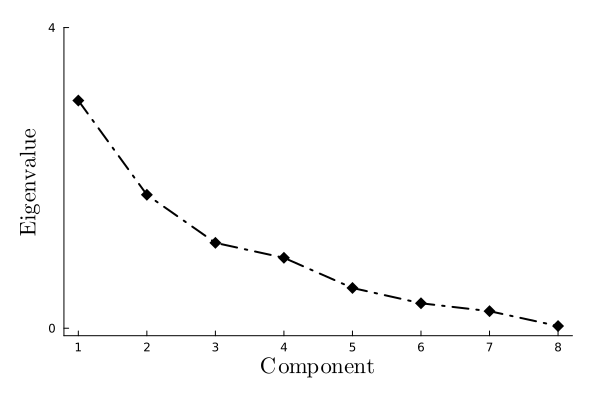

In [32]:
total_var = sum(eig_MC.values)
eig_val_decreasing = reverse(eig_MC.values)

p1a  = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
            linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
            xticks=[1, 2, 3, 4, 5, 6, 7, 8], color=:black, markersize=6, linewidth=2, yticks=[0, 4])
ylims!((-0.1, 4))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(p1a)
# savefig(p1a, "./figures/STG_MC_scree.pdf")

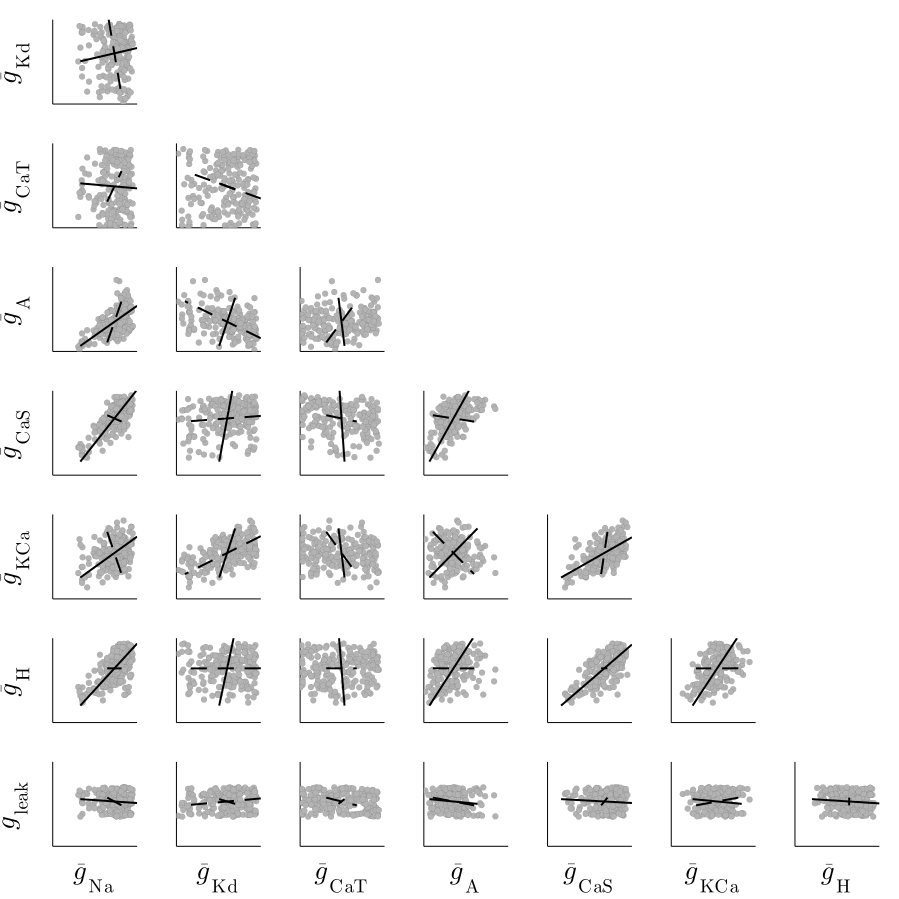

In [16]:
CC1 = scatter_matrix(eig_MC_plot, nb_channels, g_all_MC, mean_MC, Na_max, CaT_max,
                     CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max, s1*1.4, s2*1.4, :gray70, :none)
display(CC1)
savefig(CC1, "./figures/STG_MC_matrix.pdf")

In [310]:
# Computing scaling factors for homogeneous scaling
gNa_scaling = mean_MC[1] / mean_MC[8]
gCaT_scaling = mean_MC[2] / mean_MC[8]
gCaS_scaling = mean_MC[3] / mean_MC[8]
gA_scaling = mean_MC[4] / mean_MC[8]
gKCa_scaling = mean_MC[5] / mean_MC[8]
gKd_scaling = mean_MC[6] / mean_MC[8]
gH_scaling = mean_MC[7] / mean_MC[8]

# Computing alignment
scaling = [gNa_scaling, gCaT_scaling, gCaS_scaling, gA_scaling, gKCa_scaling, gKd_scaling, gH_scaling, 1]
for i = 1 : nb_channels
    scaling[i] = scaling[i] / std(g_all_MC[:, i])
end
scaling = scaling ./ norm(scaling)

PC1 = eig_MC.vectors[:, nb_channels]
PC1 = PC1 ./ norm(PC1)

alignment = abs(PC1' * scaling)
text = @sprintf "Alignement = %.2f%%" alignment*100
display(text)

"Alignement = 79.13%"

In [311]:
# Computing angles
theta_ACaS_leak = atan((gCaS_scaling/CaS_max)/
                       (gA_scaling/A_max))
theta_ACaS = atan((eig_MC_plot.vectors[:, nb_channels][3]/CaS_max)/
                  (eig_MC_plot.vectors[:, nb_channels][4]/A_max))

theta_CaSH_leak = atan((gH_scaling/H_max)/
                       (gCaS_scaling/CaS_max))
theta_CaSH = atan((eig_MC_plot.vectors[:, nb_channels][7]/H_max)/
                  (eig_MC_plot.vectors[:, nb_channels][3]/CaS_max))

theta_NaKCa_leak = atan((gKCa_scaling/KCa_max)/
                        (gNa_scaling/Na_max))
theta_NaKCa = atan((eig_MC_plot.vectors[:, nb_channels][5]/KCa_max)/
                   (eig_MC_plot.vectors[:, nb_channels][1]/Na_max))

theta_KdA_leak = atan((gA_scaling/A_max)/
                      (gKd_scaling/Kd_max))
theta_KdA = atan((eig_MC_plot.vectors[:, nb_channels][4]/A_max)/
                 (eig_MC_plot.vectors[:, nb_channels][6]/Kd_max));

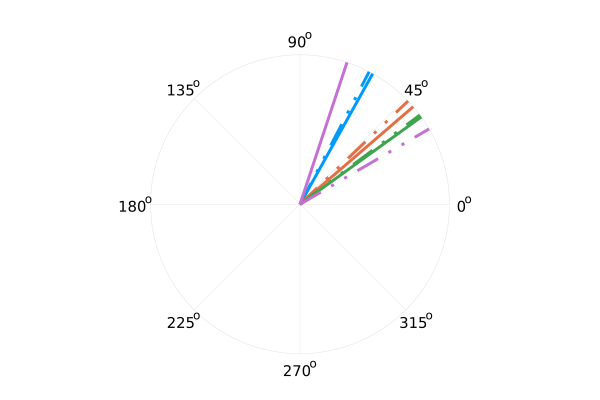

In [19]:
p1b = plot([theta_ACaS, theta_ACaS], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10)
plot!([theta_ACaS_leak, theta_ACaS_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaSH, theta_CaSH], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2)
plot!([theta_CaSH_leak, theta_CaSH_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKCa, theta_NaKCa], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3)
plot!([theta_NaKCa_leak, theta_NaKCa_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_KdA, theta_KdA], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4)
plot!([theta_KdA_leak, theta_KdA_leak], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p1b)
savefig(p1b, "./figures/STG_MC_polar_leak.pdf")

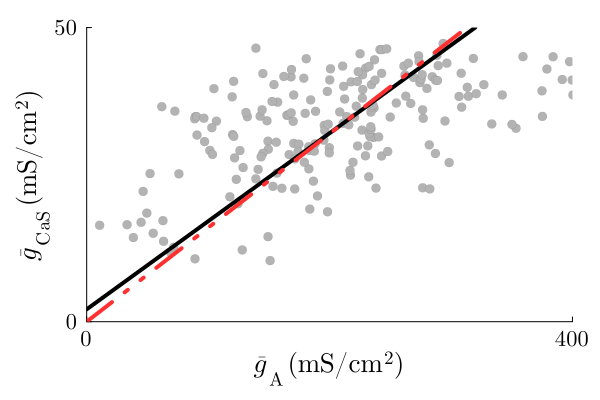

"C:\\Users\\arthu\\GitHub repositories\\CORR_2022\\STG\\figures\\neuromod_gCaSA_MC.pdf"

In [207]:
p1c = scatter(g_all_MC[:, 4], g_all_MC[:, 3], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, tickfontsize=15, yticks=([0, 50], [L"0", L"50"]),
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))

plot!([mean_MC[4] - s1*2*eig_MC_plot.vectors[:, nb_channels][4]*eig_MC_plot.values[nb_channels], 
      mean_MC[4] + s1*2*eig_MC_plot.vectors[:, nb_channels][4]*eig_MC_plot.values[nb_channels]],
      [mean_MC[3] - s1*2*eig_MC_plot.vectors[:, nb_channels][3]*eig_MC_plot.values[nb_channels], 
      mean_MC[3] + s1*2*eig_MC_plot.vectors[:, nb_channels][3]*eig_MC_plot.values[nb_channels]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_MC[4] - 0.05*gA_scaling, 
      mean_MC[4] + 0.05*gA_scaling],
      [mean_MC[3] - 0.05*gCaS_scaling, 
      mean_MC[3] + 0.05*gCaS_scaling],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p1c)
# savefig(p1c, "./figures/neuromod_gCaSA_MC.pdf")

# **Projecting data in the DICs space and computing gs(Vth) isohyperplanes of high frequency bursting neurons using Monte Carlo (Figure 2)**

In [34]:
g_all_Vth = readdlm("./data/g_all_Vth.dat")

ICs_th_Vth = readdlm("./data/ICs_th_Vth.dat");

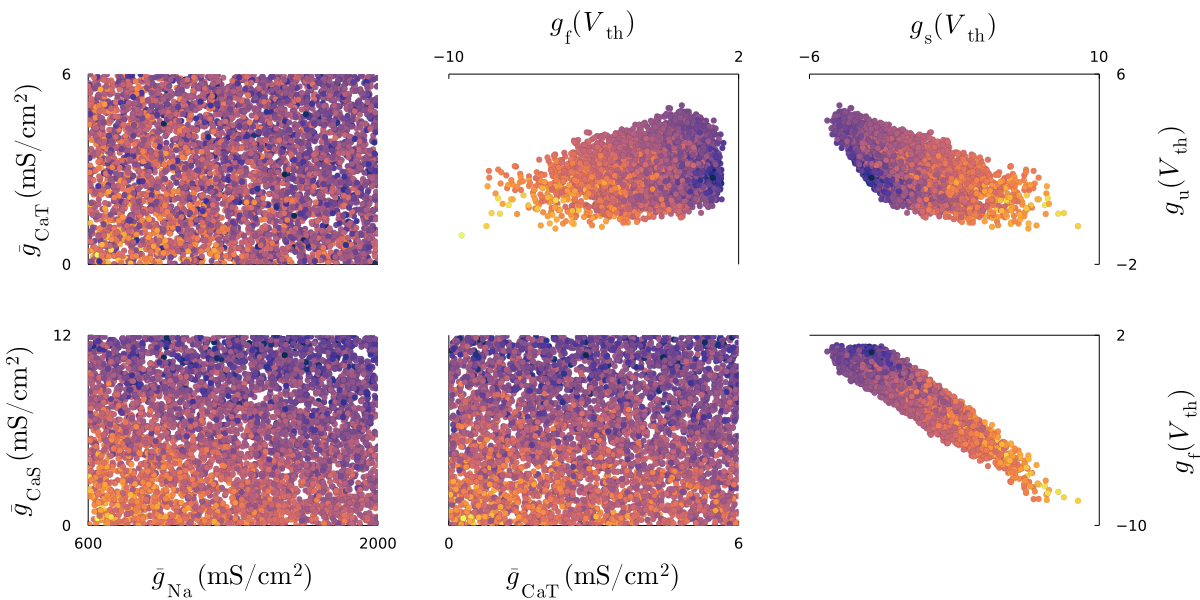

In [23]:
pNaCaS = scatter(g_all_Vth[:, 1], g_all_Vth[:, 3], label="", grid=false,
                 yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                 zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                 yticks=[0, 12], xticks=[600, 2000], markerstrokewidth=0, tickfontsize=10)

xlabel!(L"\bar{g}_\mathrm{Na}\,\mathrm{(mS/cm^2)}")
ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
ylims!((0, 12))
xlims!((600, 2000))

pCaTCaS = scatter(g_all_Vth[:, 2], g_all_Vth[:, 3], label="", grid=false,
                  yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                  zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                  yticks=false, xticks=[0, 6], markerstrokewidth=0, tickfontsize=10)

xlabel!(L"\bar{g}_\mathrm{CaT}\,\mathrm{(mS/cm^2)}")
ylims!((0, 12))
xlims!((0, 6))

pNaCaT = scatter(g_all_Vth[:, 1], g_all_Vth[:, 2], label="", grid=false,
                 yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                 zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                 yticks=[0, 6], xticks=false, markerstrokewidth=0, tickfontsize=10)

ylabel!(L"\bar{g}_\mathrm{CaT}\,\mathrm{(mS/cm^2)}")
ylims!((0, 6))
xlims!((600, 2000))

pgfgu = scatter(ICs_th_Vth[:, 3], ICs_th_Vth[:, 6], label="", grid=false,
                yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                xticks=[-10, 2], yticks=false, mirror=true, markerstrokewidth=0, tickfontsize=10)

xlabel!(L"g_\mathrm{f}(V_\mathrm{th})")
ylims!((-2, 6))
xlims!((-10, 2))

pgsgu = scatter(ICs_th_Vth[:, 4], ICs_th_Vth[:, 6], label="", grid=false,
                yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                xticks=[-6, 10], yticks=[-2, 6], mirror=true, markerstrokewidth=0, tickfontsize=10)

xlabel!(L"g_\mathrm{s}(V_\mathrm{th})")
ylabel!(L"g_\mathrm{u}(V_\mathrm{th})")
ylims!((-2, 6))
xlims!((-6, 10))

pgsgf = scatter(ICs_th_Vth[:, 4], ICs_th_Vth[:, 3], label="", grid=false,
                yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
                zcolor=ICs_th_Vth[:, 1], c=cgrad(:thermal, rev=false), legend=false,
                xticks=false, yticks=[-10, 2], mirror=true, markerstrokewidth=0, tickfontsize=10)

ylabel!(L"g_\mathrm{f}(V_\mathrm{th})")
ylims!((-10, 2))
xlims!((-6, 10))


CC2 = plot(pNaCaT, pgfgu, pgsgu, pNaCaS, pCaTCaS, pgsgf, size =(1200, 600),
           layout = @layout([° ° °; ° ° °]), margin=7Plots.mm)
display(CC2)
savefig(CC2, "./figures/STG_DICs_Vth.pdf")

In [29]:
# Extracting threshold voltage and weighting factors for a specific neuron
Random.seed!(543)
(gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_MC[Int(ceil(rand(1, 1)[1]*ncells)), :]
(ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, 0., gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak)
Vth = V[ith]

# Defining the 3 time constants of the 3 timescales
tau_fast = tau_mNa(Vth)
tau_slow = tau_mKd(Vth)
tau_uslow = tau_mH(Vth)

# Computing the wfs(V) and wsu(V) for all gating variables
(wfs_mNa, wsu_mNa) = var_contribution(tau_mNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hNa, wsu_hNa) = var_contribution(tau_hNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaT, wsu_mCaT) = var_contribution(tau_mCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaT, wsu_hCaT) = var_contribution(tau_hCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaS, wsu_mCaS) = var_contribution(tau_mCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaS, wsu_hCaS) = var_contribution(tau_hCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mA, wsu_mA) = var_contribution(tau_mA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hA, wsu_hA) = var_contribution(tau_hA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKd, wsu_mKd) = var_contribution(tau_mKd(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKCa, wsu_mKCa) = var_contribution(tau_mKCa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mH, wsu_mH) = var_contribution(tau_mH(Vth), tau_fast, tau_slow, tau_uslow)

# Modifying scaling factors
s2 = 1.3

# Computing derivatives of gs(Vth) with respect to maximal ion channel conductances
dgs_dNa = (wsu_mNa - wfs_mNa)*3*mNa_inf(Vth)^2*hNa_inf(Vth)*(Vth-VNa)*dmNa(Vth) + 
          (wsu_hNa - wfs_hNa)*mNa_inf(Vth)^3*(Vth-VNa)*dhNa(Vth)
dgs_dCaS = (wsu_mCaS - wfs_mCaS)*3*mCaS_inf(Vth)^2*hCaS_inf(Vth)*(Vth-VCa)*dmCaS(Vth) + 
           (wsu_hCaS - wfs_hCaS)*mCaS_inf(Vth)^3*(Vth-VCa)*dhCaS(Vth)
dgs_dCaT = (wsu_mCaT - wfs_mCaT)*3*mCaT_inf(Vth)^2*hCaT_inf(Vth)*(Vth-VCa)*dmCaT(Vth) + 
           (wsu_hCaT - wfs_hCaT)*mCaT_inf(Vth)^3*(Vth-VCa)*dhCaT(Vth)
dgs_dKd = (wsu_mKd - wfs_mKd)*4*mKd_inf(Vth)^3*(Vth-VK)*dmKd(Vth)
dgs_dA = (wsu_mA - wfs_mA)*3*mA_inf(Vth)^2*hA_inf(Vth)*(Vth-VK)*dmA(Vth) + 
         (wsu_hA - wfs_hA)*mA_inf(Vth)^3*(Vth-VK)*dhA(Vth)
dgs_dH = (wsu_mH - wfs_mH)*(Vth-VH)*dmH(Vth);

In [30]:
theta_ACaS_DIC = -atan((dgs_dA/CaS_max)/(dgs_dCaS/A_max))
theta_ACaS4 = atan((eig_MC_plot.vectors[:, nb_channels-4][3]/CaS_max)/
                   (eig_MC_plot.vectors[:, nb_channels-4][4]/A_max))

theta_CaTCaS_DIC = -atan((dgs_dCaT/CaS_max)/(dgs_dCaS/CaT_max))
theta_CaTCaS = atan((eig_MC_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                    (eig_MC_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd_DIC = -atan((dgs_dNa/Kd_max)/(dgs_dKd/Na_max))
theta_NaKd = atan((eig_MC_plot.vectors[:, nb_channels-1][6]/Kd_max)/
                  (eig_MC_plot.vectors[:, nb_channels-1][1]/Na_max))

theta_CaTA_DIC = -atan((dgs_dCaT/A_max)/(dgs_dA/CaT_max))
theta_CaTA4 = atan((eig_MC_plot.vectors[:, nb_channels-3][4]/A_max)/
                   (eig_MC_plot.vectors[:, nb_channels-3][2]/CaT_max));

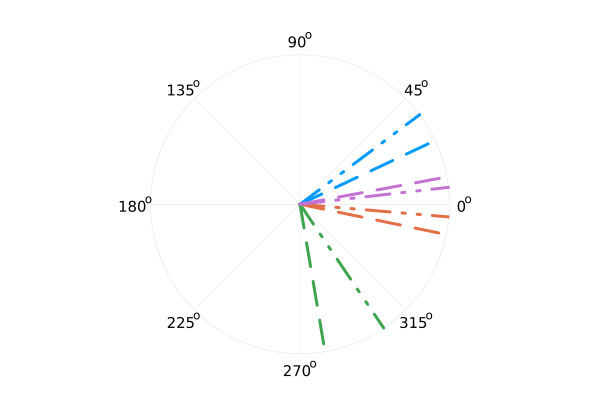

In [33]:
p2a = plot([theta_ACaS4, theta_ACaS4], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10, linestyle=:dash)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS, theta_CaTCaS], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd, theta_NaKd], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA4, theta_CaTA4], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p2a)
# savefig(p2a, "./figures/STG_MC_polar_DIC.pdf")

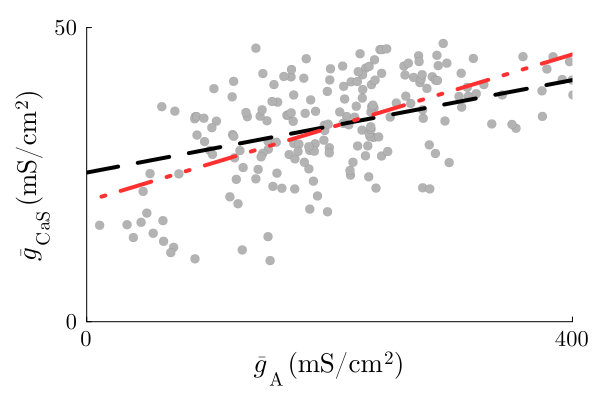

In [45]:
p2b = scatter(g_all_MC[:, 4], g_all_MC[:, 3], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., markersize=5, tickfontsize=15, yticks=([0, 50], [L"0", L"50"]),
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))

# plot!([mean_MC[4] - s2*2*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1], 
#       mean_MC[4] + s2*2*eig_MC_plot.vectors[:, nb_channels-1][4]*eig_MC_plot.values[nb_channels-1]],
#       [mean_MC[3] - s2*2*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1], 
#       mean_MC[3] + s2*2*eig_MC_plot.vectors[:, nb_channels-1][3]*eig_MC_plot.values[nb_channels-1]],
#       arrow=false, color=:black, linewidth=1.5, label="", linestyle=:dash)

plot!([mean_MC[4] - s2*10*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4], 
      mean_MC[4] + s2*10*eig_MC_plot.vectors[:, nb_channels-4][4]*eig_MC_plot.values[nb_channels-4]],
      [mean_MC[3] - s2*10*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4], 
      mean_MC[3] + s2*10*eig_MC_plot.vectors[:, nb_channels-4][3]*eig_MC_plot.values[nb_channels-4]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC[4] - 10000000* dgs_dCaS, mean_MC[4] + 10000000*dgs_dCaS],
      [mean_MC[3] + 10000000*dgs_dA, mean_MC[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p2b)
# savefig(p2b, "./figures/neuromod_gCaSA_MC_DIC.pdf")

# **Computing PCA of high frequency tonic spiking neurons using Monte Carlo and separated according to excitability types (Figure 3)**

In [194]:
# Defining limits for the plots
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

g_all_MC_spiking = readdlm("./data/g_all_MC_spiking.dat");

In [195]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on spiking point cloud
mean_MC_spiking = zeros(1, nb_channels)
mean!(mean_MC_spiking, g_all_MC_spiking)

# Defining scaling factors
s1 = 1.3
s2 = 1.3

# Normalizing data before applying PCA
g_all_MC_spiking_norm = deepcopy(g_all_MC_spiking)
for i = 1 : nb_channels
    g_all_MC_spiking_norm[:, i] = g_all_MC_spiking[:, i] / std(g_all_MC_spiking[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_spiking = cov(g_all_MC_spiking_norm)
eig_MC_spiking = eigen(cov_matrix_MC_spiking, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_spiking_plot = deepcopy(eig_MC_spiking)
for i = 1 : nb_channels
    eig_MC_spiking_plot.vectors[i, :] = eig_MC_spiking_plot.vectors[i, :] * std(g_all_MC_spiking[:, i])
end

In [196]:
# Initializing some variables
gsth = zeros(ncells)

# Loop over all neurons to compute gs(Vth)
for i = 1 : ncells
    # Extracting the maximal ion channel conductances
    (gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_MC_spiking[i, :]

    # Input current definition
    Iapp = 0.

    # DICs computation
    (ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, Iapp, gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak)
    gsth[i] = gs[ith]
end

# Defining thresholds and separating according to axcitability types
gsth_thresh = [-1, 3, 16]
g_all_MC_spiking1 = g_all_MC_spiking[findall(gsth .< gsth_thresh[1]), :]
g_all_MC_spiking2 = g_all_MC_spiking[findall(gsth .> gsth_thresh[1] .&& gsth .< gsth_thresh[2]), :]
g_all_MC_spiking3 = g_all_MC_spiking[findall(gsth .> gsth_thresh[2] .&& gsth .< gsth_thresh[3]), :];

In [197]:
# Means on spiking point cloud
mean_MC_spiking1 = zeros(1, nb_channels)
mean!(mean_MC_spiking1, g_all_MC_spiking1)

# Normalizing data before applying PCA
g_all_MC_spiking1_norm = deepcopy(g_all_MC_spiking1)
for i = 1 : nb_channels
    g_all_MC_spiking1_norm[:, i] = g_all_MC_spiking1[:, i] / std(g_all_MC_spiking1[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_spiking1 = cov(g_all_MC_spiking1_norm)
eig_MC_spiking1 = eigen(cov_matrix_MC_spiking1, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_spiking1_plot = deepcopy(eig_MC_spiking1)
for i = 1 : nb_channels
    eig_MC_spiking1_plot.vectors[i, :] = eig_MC_spiking1_plot.vectors[i, :] * std(g_all_MC_spiking1[:, i])
end

# Means on spiking point cloud
mean_MC_spiking2 = zeros(1, nb_channels)
mean!(mean_MC_spiking2, g_all_MC_spiking2)

# Normalizing data before applying PCA
g_all_MC_spiking2_norm = deepcopy(g_all_MC_spiking2)
for i = 1 : nb_channels
    g_all_MC_spiking2_norm[:, i] = g_all_MC_spiking2[:, i] / std(g_all_MC_spiking2[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_spiking2 = cov(g_all_MC_spiking2_norm)
eig_MC_spiking2 = eigen(cov_matrix_MC_spiking2, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_spiking2_plot = deepcopy(eig_MC_spiking2)
for i = 1 : nb_channels
    eig_MC_spiking2_plot.vectors[i, :] = eig_MC_spiking2_plot.vectors[i, :] * std(g_all_MC_spiking2[:, i])
end

# Means on spiking point cloud
mean_MC_spiking3 = zeros(1, nb_channels)
mean!(mean_MC_spiking3, g_all_MC_spiking3)

# Normalizing data before applying PCA
g_all_MC_spiking3_norm = deepcopy(g_all_MC_spiking3)
for i = 1 : nb_channels
    g_all_MC_spiking3_norm[:, i] = g_all_MC_spiking3[:, i] / std(g_all_MC_spiking3[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_spiking3 = cov(g_all_MC_spiking3_norm)
eig_MC_spiking3 = eigen(cov_matrix_MC_spiking3, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_spiking3_plot = deepcopy(eig_MC_spiking3)
for i = 1 : nb_channels
    eig_MC_spiking3_plot.vectors[i, :] = eig_MC_spiking3_plot.vectors[i, :] * std(g_all_MC_spiking3[:, i])
end

In [198]:
# Extracting threshold voltage and weighting factors for a specific neuron
Random.seed!(543)
(gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak) = g_all_MC_spiking[Int(ceil(rand(1, 1)[1]*ncells)), :]
(ith, iosc, gf, gs, gu, gin, Istatic) = DICs(V, 0., gNa, gCaT, gCaS, gA, gKCa, gKd, gH, gleak)
Vth = V[ith]

# Defining the 3 time constants of the 3 timescales
tau_fast = tau_mNa(Vth)
tau_slow = tau_mKd(Vth)
tau_uslow = tau_mH(Vth)

# Computing the wfs(V) and wsu(V) for all gating variables
(wfs_mNa, wsu_mNa) = var_contribution(tau_mNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hNa, wsu_hNa) = var_contribution(tau_hNa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaT, wsu_mCaT) = var_contribution(tau_mCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaT, wsu_hCaT) = var_contribution(tau_hCaT(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mCaS, wsu_mCaS) = var_contribution(tau_mCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hCaS, wsu_hCaS) = var_contribution(tau_hCaS(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mA, wsu_mA) = var_contribution(tau_mA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_hA, wsu_hA) = var_contribution(tau_hA(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKd, wsu_mKd) = var_contribution(tau_mKd(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mKCa, wsu_mKCa) = var_contribution(tau_mKCa(Vth), tau_fast, tau_slow, tau_uslow)
(wfs_mH, wsu_mH) = var_contribution(tau_mH(Vth), tau_fast, tau_slow, tau_uslow)

# Computing derivatives of gs(Vth) with respect to maximal ion channel conductances
dgs_dNa = (wsu_mNa - wfs_mNa)*3*mNa_inf(Vth)^2*hNa_inf(Vth)*(Vth-VNa)*dmNa(Vth) + 
          (wsu_hNa - wfs_hNa)*mNa_inf(Vth)^3*(Vth-VNa)*dhNa(Vth)
dgs_dCaS = (wsu_mCaS - wfs_mCaS)*3*mCaS_inf(Vth)^2*hCaS_inf(Vth)*(Vth-VCa)*dmCaS(Vth) + 
           (wsu_hCaS - wfs_hCaS)*mCaS_inf(Vth)^3*(Vth-VCa)*dhCaS(Vth)
dgs_dCaT = (wsu_mCaT - wfs_mCaT)*3*mCaT_inf(Vth)^2*hCaT_inf(Vth)*(Vth-VCa)*dmCaT(Vth) + 
           (wsu_hCaT - wfs_hCaT)*mCaT_inf(Vth)^3*(Vth-VCa)*dhCaT(Vth)
dgs_dKd = (wsu_mKd - wfs_mKd)*4*mKd_inf(Vth)^3*(Vth-VK)*dmKd(Vth)
dgs_dA = (wsu_mA - wfs_mA)*3*mA_inf(Vth)^2*hA_inf(Vth)*(Vth-VK)*dmA(Vth) + 
         (wsu_hA - wfs_hA)*mA_inf(Vth)^3*(Vth-VK)*dhA(Vth)
dgs_dH = (wsu_mH - wfs_mH)*(Vth-VH)*dmH(Vth);

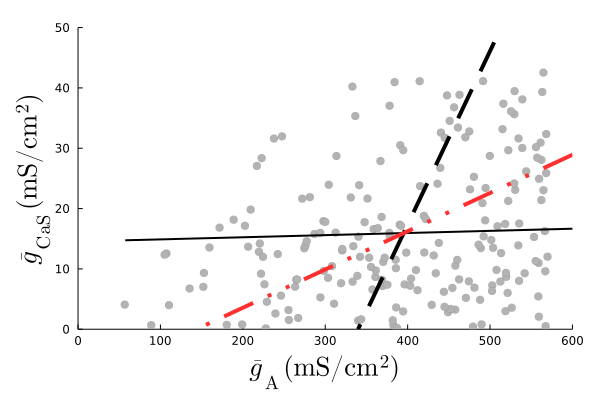

In [34]:
p3a = scatter(g_all_MC_spiking[:, 4], g_all_MC_spiking[:, 3], label="", color=:gray70, grid=false, markersize=5, 
              markerstrokewidth=0., yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm)

plot!([mean_MC_spiking[4] - s1*2*eig_MC_spiking_plot.vectors[:, nb_channels][4]*eig_MC_spiking_plot.values[nb_channels], 
      mean_MC_spiking[4] + s1*2*eig_MC_spiking_plot.vectors[:, nb_channels][4]*eig_MC_spiking_plot.values[nb_channels]],
      [mean_MC_spiking[3] - s1*2*eig_MC_spiking_plot.vectors[:, nb_channels][3]*eig_MC_spiking_plot.values[nb_channels], 
      mean_MC_spiking[3] + s1*2*eig_MC_spiking_plot.vectors[:, nb_channels][3]*eig_MC_spiking_plot.values[nb_channels]],
      arrow=false, color=:black, linewidth=2, label="")

plot!([mean_MC_spiking[4] - s2*2*eig_MC_spiking_plot.vectors[:, nb_channels-1][4]*eig_MC_spiking_plot.values[nb_channels-1], 
      mean_MC_spiking[4] + s2*2*eig_MC_spiking_plot.vectors[:, nb_channels-1][4]*eig_MC_spiking_plot.values[nb_channels-1]],
      [mean_MC_spiking[3] - s2*2*eig_MC_spiking_plot.vectors[:, nb_channels-1][3]*eig_MC_spiking_plot.values[nb_channels-1], 
      mean_MC_spiking[3] + s2*2*eig_MC_spiking_plot.vectors[:, nb_channels-1][3]*eig_MC_spiking_plot.values[nb_channels-1]],
      arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_MC_spiking[4] - 10000000* dgs_dCaS, mean_MC_spiking[4] + 10000000*dgs_dCaS],
      [mean_MC_spiking[3] + 10000000*dgs_dA, mean_MC_spiking[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p3a)
savefig(p3a, "./figures/neuromod_gCaSA_MC_DIC_spiking.pdf")

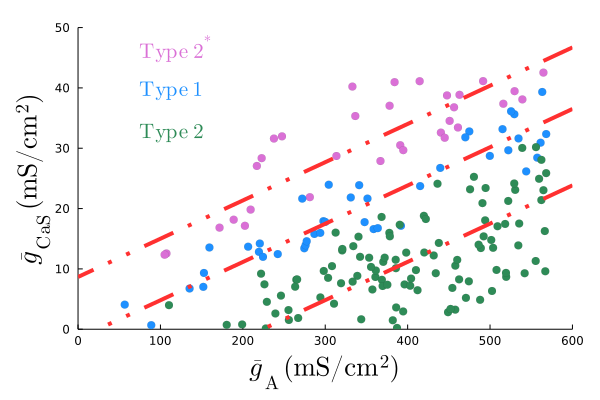

In [55]:
p3b = scatter(g_all_MC_spiking1[:, 4], g_all_MC_spiking1[:, 3], label="", color=:orchid, grid=false, markersize=5,
              markerstrokewidth=0., yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm)

plot!([mean_MC_spiking1[4] - 10000000* dgs_dCaS, mean_MC_spiking1[4] + 10000000*dgs_dCaS],
      [mean_MC_spiking1[3] + 10000000*dgs_dA, mean_MC_spiking1[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

scatter!(g_all_MC_spiking2[:, 4], g_all_MC_spiking2[:, 3], label="", color=:dodgerblue, grid=false,  markersize=5,
         markerstrokewidth=0., yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm)

plot!([mean_MC_spiking2[4] - 10000000* dgs_dCaS, mean_MC_spiking2[4] + 10000000*dgs_dCaS],
      [mean_MC_spiking2[3] + 10000000*dgs_dA, mean_MC_spiking2[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

scatter!(g_all_MC_spiking3[:, 4], g_all_MC_spiking3[:, 3], label="", color=:seagreen, grid=false,  markersize=5,
         markerstrokewidth=0., yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm)

plot!([mean_MC_spiking3[4] - 10000000* dgs_dCaS, mean_MC_spiking3[4] + 10000000*dgs_dCaS],
      [mean_MC_spiking3[3] + 10000000*dgs_dA, mean_MC_spiking3[3] - 10000000*dgs_dA],
      arrow=false, color=:firebrick1, linewidth=4, label="", linestyle=:dashdotdot)

gsth_thresh1 = gsth_thresh[1]
annotate!(75, 47, Plots.text("\$\\textrm{Type}\\, \\, 2^\\textrm{*}\$", :orchid, :left, 14))

gsth_thresh2 = gsth_thresh[2]
annotate!(75, 40, Plots.text("\$\\textrm{Type}\\, \\, 1\$", :dodgerblue, :left, 14))

gsth_thresh3 = gsth_thresh[3]
annotate!(75, 33, Plots.text("\$\\textrm{Type}\\, \\, 2\$", :seagreen, :left, 14))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p3b)
savefig(p3b, "./figures/neuromod_gCaSA_MC_DIC_separated.pdf")

In [45]:
theta_ACaS_DIC = -atan((dgs_dA/CaS_max)/(dgs_dCaS/A_max))
theta_ACaS = atan((eig_MC_spiking_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                  (eig_MC_spiking_plot.vectors[:, nb_channels-1][4]/A_max))

theta_CaTCaS_DIC = -atan((dgs_dCaT/CaS_max)/(dgs_dCaS/CaT_max))
theta_CaTCaS = atan((eig_MC_spiking_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                    (eig_MC_spiking_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd_DIC = -atan((dgs_dNa/Kd_max)/(dgs_dKd/Na_max))
theta_NaKd = atan((eig_MC_spiking_plot.vectors[:, nb_channels-1][6]/Kd_max)/
                  (eig_MC_spiking_plot.vectors[:, nb_channels-1][1]/Na_max))

theta_CaTA_DIC = -atan((dgs_dCaT/A_max)/(dgs_dA/CaT_max))
theta_CaTA = atan((eig_MC_spiking_plot.vectors[:, nb_channels-1][4]/A_max)/
                  (eig_MC_spiking_plot.vectors[:, nb_channels-1][2]/CaT_max));

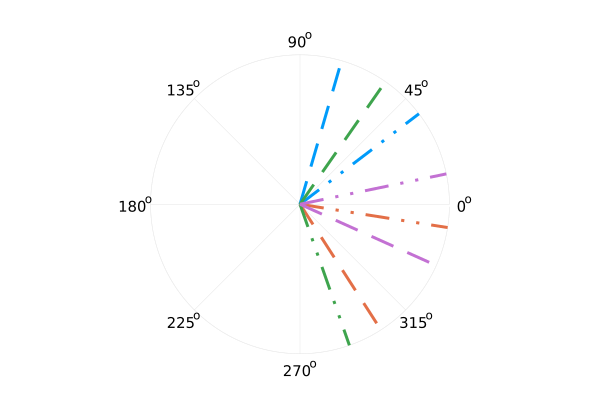

In [46]:
p3c = plot([theta_ACaS, theta_ACaS], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10, linestyle=:dash)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS, theta_CaTCaS], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd, theta_NaKd], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA, theta_CaTA], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p3c)
savefig(p3c, "./figures/STG_MC_polar_DIC_spiking.pdf")

In [47]:
theta_ACaS1 = atan((eig_MC_spiking1_plot.vectors[:, nb_channels][3]/CaS_max)/
                   (eig_MC_spiking1_plot.vectors[:, nb_channels][4]/A_max))

theta_CaTCaS1 = atan((eig_MC_spiking1_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                     (eig_MC_spiking1_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd1 = atan((eig_MC_spiking1_plot.vectors[:, nb_channels][6]/Kd_max)/
                   (eig_MC_spiking1_plot.vectors[:, nb_channels][1]/Na_max))

theta_CaTA1 = atan((eig_MC_spiking1_plot.vectors[:, nb_channels-1][4]/A_max)/
                   (eig_MC_spiking1_plot.vectors[:, nb_channels-1][2]/CaT_max));

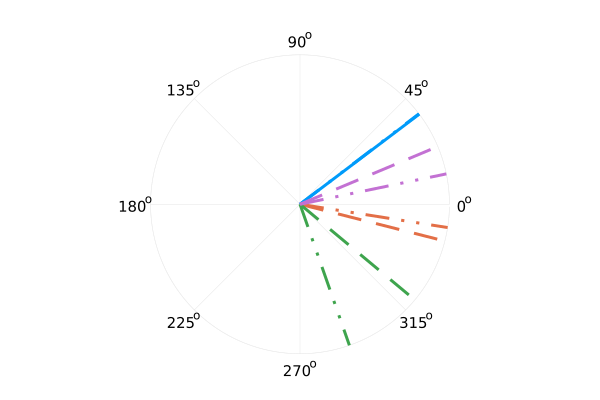

In [48]:
p3d = plot([theta_ACaS1, theta_ACaS1], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS1, theta_CaTCaS1], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd1, theta_NaKd1], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA1, theta_CaTA1], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p3d)
savefig(p3d, "./figures/STG_MC_polar_DIC_spiking1.pdf")

In [49]:
theta_ACaS2 = atan((eig_MC_spiking2_plot.vectors[:, nb_channels][3]/CaS_max)/
                   (eig_MC_spiking2_plot.vectors[:, nb_channels][4]/A_max))

theta_CaTCaS2 = atan((eig_MC_spiking2_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                     (eig_MC_spiking2_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd2 = atan((eig_MC_spiking2_plot.vectors[:, nb_channels-1][6]/Kd_max)/
                   (eig_MC_spiking2_plot.vectors[:, nb_channels-1][1]/Na_max))

theta_CaTA2 = atan((eig_MC_spiking2_plot.vectors[:, nb_channels-1][4]/A_max)/
                   (eig_MC_spiking2_plot.vectors[:, nb_channels-1][2]/CaT_max));

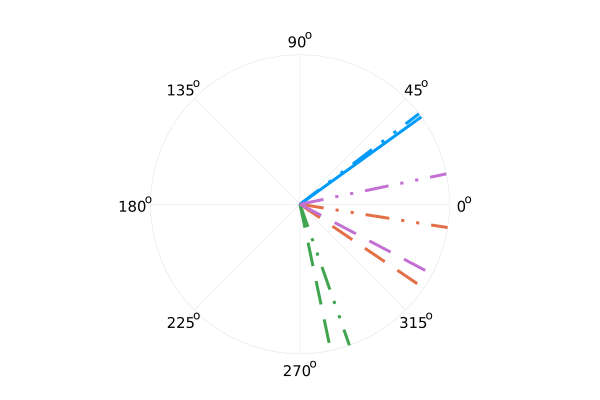

In [50]:
p3e = plot([theta_ACaS2, theta_ACaS2], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS2, theta_CaTCaS2], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd2, theta_NaKd2], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA2, theta_CaTA2], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p3e)
savefig(p3e, "./figures/STG_MC_polar_DIC_spiking2.pdf")

In [51]:
theta_ACaS3 = atan((eig_MC_spiking3_plot.vectors[:, nb_channels][3]/CaS_max)/
                   (eig_MC_spiking3_plot.vectors[:, nb_channels][4]/A_max))

theta_CaTCaS3 = atan((eig_MC_spiking3_plot.vectors[:, nb_channels-1][3]/CaS_max)/
                     (eig_MC_spiking3_plot.vectors[:, nb_channels-1][2]/CaT_max))

theta_NaKd3 = atan((eig_MC_spiking3_plot.vectors[:, nb_channels-1][6]/Kd_max)/
                   (eig_MC_spiking3_plot.vectors[:, nb_channels-1][1]/Na_max))

theta_CaTA3 = atan((eig_MC_spiking3_plot.vectors[:, nb_channels-1][4]/A_max)/
                   (eig_MC_spiking3_plot.vectors[:, nb_channels-1][2]/CaT_max));

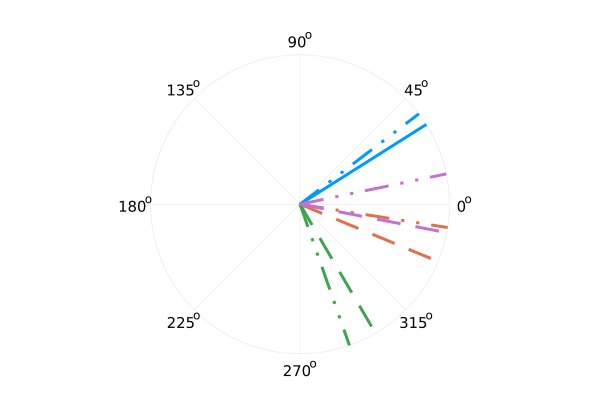

In [52]:
p3f = plot([theta_ACaS3, theta_ACaS3], [0, 1], proj=:polar, linewidth=3, label="", yticks=[], 
           yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, 
           color=1, xtickfontsize=10)
plot!([theta_ACaS_DIC, theta_ACaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=1, linestyle=:dashdotdot)
plot!([theta_CaTCaS3, theta_CaTCaS3], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dash)
plot!([theta_CaTCaS_DIC, theta_CaTCaS_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=2, linestyle=:dashdotdot)
plot!([theta_NaKd3, theta_NaKd3], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dash)
plot!([theta_NaKd_DIC, theta_NaKd_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=3, linestyle=:dashdotdot)
plot!([theta_CaTA3, theta_CaTA3], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dash)
plot!([theta_CaTA_DIC, theta_CaTA_DIC], [0, 1], proj=:polar, linewidth=3, label="", 
      color=4, linestyle=:dashdotdot)
ylims!(0, 1)
display(p3f)
savefig(p3f, "./figures/STG_MC_polar_DIC_spiking3.pdf")

# **Computing PCA of high frequency bursting neurons using DICs method (Figure 4)**

In [12]:
g_all_bursting = readdlm("./data/g_all_bursting.dat")
g_all_bursting_DIC = readdlm("./data/g_all_bursting_DIC.dat")
g_all_bursting_leak = readdlm("./data/g_all_bursting_leak.dat")
g_all_bursting_many = readdlm("./data/g_all_bursting_many.dat")

# Definition of the number of cells in the random set
const ncells = 500;

In [13]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on bursting point cloud
mean_bursting = zeros(1, nb_channels)
mean!(mean_bursting, g_all_bursting)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

# Normalizing data before applying PCA
g_all_bursting_norm = deepcopy(g_all_bursting)
for i = 1 : nb_channels
    g_all_bursting_norm[:, i] = g_all_bursting[:, i] / std(g_all_bursting[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting = cov(g_all_bursting_norm)
eig_bursting = eigen(cov_matrix_bursting, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_plot = deepcopy(eig_bursting)
for i = 1 : nb_channels
    eig_bursting_plot.vectors[i, :] = eig_bursting_plot.vectors[i, :] * std(g_all_bursting[:, i])
end

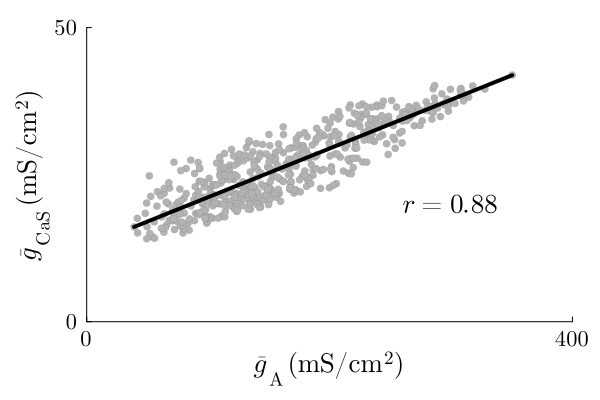

"C:\\Users\\arthu\\GitHub repositories\\CORR_2022\\STG\\figures\\PCA_STG_neuromod_gCaSA_bursting.pdf"

In [40]:
p4a = scatter(g_all_bursting[:, 4], g_all_bursting[:, 3], label="", color=:gray70, grid=false,
              yguidefontsize=18, xguidefontsize=18, legendfontsize=12, margin=5Plots.mm,
              markerstrokewidth=0., yticks=([0, 50], [L"0", L"50"]), tickfontsize=15, 
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))
s1 = 1000
s2 = 2000
# plot!([mean_bursting[4] - s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels], 
#        mean_bursting[4] + s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels]],
#        [mean_bursting[3] - s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels], 
#        mean_bursting[3] + s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels]],
#        arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

# plot!([mean_bursting[4] - s2*1.5*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1], 
#        mean_bursting[4] + s2*1.5*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1]],
#        [mean_bursting[3] - s2*1.5*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1], 
#        mean_bursting[3] + s2*1.5*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1]],
#        arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

line_43 = fit(g_all_bursting[:, 4], g_all_bursting[:, 3], 1)
s0 = minimum(g_all_bursting[:, 4])
sn = maximum(g_all_bursting[:, 4])
plot!([s0, sn], [line_43(s0), line_43(sn)], linewidth=4, label="", linecolor="black")

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(300, 20, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p4a)
savefig(p4a, "./figures/PCA_STG_neuromod_gCaSA_bursting.pdf")

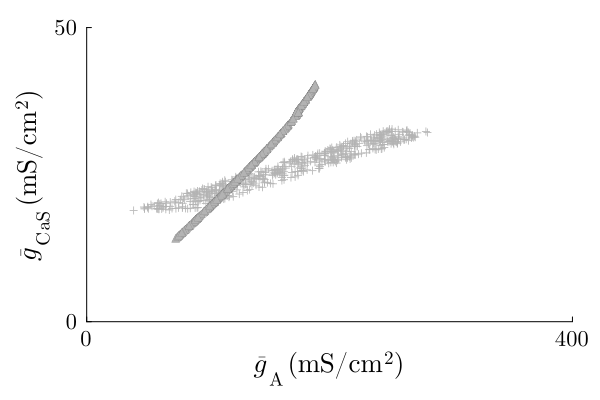

In [243]:
p4b = scatter(g_all_bursting_DIC[:, 4], g_all_bursting_DIC[:, 3], label="", 
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, legend=false, 
              yticks=([0, 50], [L"0", L"50"]), tickfontsize=15, 
              xticks=([0, 400], [L"0", L"400"]), size=(600, 400))
scatter!(g_all_bursting_leak[:, 4], g_all_bursting_leak[:, 3], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p4b)
savefig(p4b, "./figures/neuromod_gCaSA_separation_bursting.pdf")

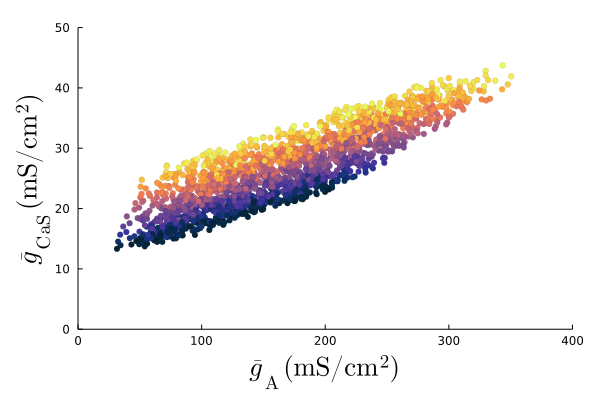

In [59]:
p4c = scatter(g_all_bursting_many[:, 4], g_all_bursting_many[:, 3], label="", 
              zcolor=g_all_bursting_many[:, 8], grid=false, yguidefontsize=18, xguidefontsize=18, 
              legendfontsize=12, margin=5Plots.mm, c=cgrad(:thermal, rev=false), legend=false, 
              markerstrokewidth=0.)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(p4c)
savefig(p4c, "./figures/neuromod_many_gCaSA_zgleak_bursting.pdf")

# **Computing PCA of neuromodulated neurons using DICs method (Figure 5)**

In [3]:
g_all_spiking = readdlm("./data/g_all_spiking.dat")
g_all_spiking_DIC = readdlm("./data/g_all_spiking_DIC.dat")
g_all_spiking_leak = readdlm("./data/g_all_spiking_leak.dat")

g_all_doublets = readdlm("./data/g_all_doublets.dat")
g_all_doublets_DIC = readdlm("./data/g_all_doublets_DIC.dat")
g_all_doublets_leak = readdlm("./data/g_all_doublets_leak.dat")

burstiness_doublets = readdlm("./data/burstiness_doublets.dat")
burstiness_doublets_plot = readdlm("./data/burstiness_doublets_plot.dat")
burstiness_doublets_DIC = readdlm("./data/burstiness_doublets_DIC.dat")
burstiness_doublets_DIC_plot = readdlm("./data/burstiness_doublets_DIC_plot.dat")
burstiness_doublets_leak = readdlm("./data/burstiness_doublets_leak.dat")
burstiness_doublets_leak_plot = readdlm("./data/burstiness_doublets_leak_plot.dat")
burstiness_bursting = readdlm("./data/burstiness_bursting.dat")
burstiness_bursting_DIC = readdlm("./data/burstiness_bursting_DIC.dat")
burstiness_bursting_leak = readdlm("./data/burstiness_bursting_leak.dat");

In [4]:
# Defining colors for the color map
mySalmon = RGB{Float64}(243. / 255., 124. / 255., 130. / 255.)
myYellow = RGB{Float64}(253. / 255., 211. / 255., 44. / 255.)
mycmap = ColorScheme([mySalmon, myYellow]);

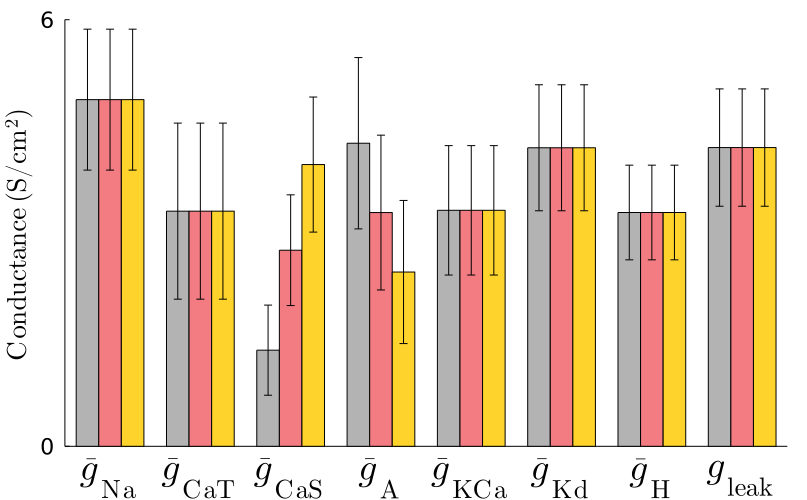

In [69]:
# Defining the number of conductances
nb_channels = 8

# Defining a matrix containing all conductances
g_all_bar = zeros(ncells, nb_channels*3)
scaling =  [1, 700, 150, 15, 30, 25, 9000, 400000]
g_all_spiking_bar = g_all_spiking ./ 1e3
g_all_doublets_bar = g_all_doublets ./ 1e3
g_all_bursting_bar = g_all_bursting ./ 1e3
for i = 1 : nb_channels
    g_all_bar[:, (i-1)*3 + 1] = g_all_spiking_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 2] = g_all_doublets_bar[:, i] .* scaling[i]
    g_all_bar[:, (i-1)*3 + 3] = g_all_bursting_bar[:, i] .* scaling[i]
end

p4a = bar([1:4:29], mean(g_all_bar[:, 1:3:22], dims=1)', label="", grid=false, yguidefontsize=18, 
          color=:gray70, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
          margin=3Plots.mm, yticks=[0, 6],  xrotation=0, xticks=false, 
          yerror=std(g_all_bar[:, 1:3:22], dims=1)', bar_width=1, ylabel=L"\mathrm{Conductance}\,\,\mathrm{(S/cm^2)}")

bar!([2:4:30], mean(g_all_bar[:, 2:3:23], dims=1)', label="", grid=false, yguidefontsize=18, 
    color=mySalmon, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, 
    margin=3Plots.mm, yticks=[0, 6],  xrotation=0, xticks=false, 
    yerror=std(g_all_bar[:, 2:3:23], dims=1)', bar_width=1)

bar!([3:4:31], mean(g_all_bar[:, 3:3:24], dims=1)', label="", grid=false, yguidefontsize=18, 
    color=myYellow, ytickfontsize=15, xguidefontsize=15, legendfontsize=12, xtickfontsize=25,
    margin=3Plots.mm, yticks=[0, 6],  xrotation=0, yerror=std(g_all_bar[:, 3:3:24], dims=1)', 
    bar_width=1, xticks=(2:4:30, [L"\bar{g}_\mathrm{Na}", L"\bar{g}_\mathrm{CaT}", L"\bar{g}_\mathrm{CaS}", 
                                  L"\bar{g}_\mathrm{A}", L"\bar{g}_\mathrm{KCa}", L"\bar{g}_\mathrm{Kd}", 
                                  L"\bar{g}_\mathrm{H}", L"g_\mathrm{leak}"]))

xlims!((0., 32.))
ylims!((0, 6))

CC5 = plot(p4a, layout=(1, 1), legend=false, size=(807,500, 300))
display(CC5)
savefig(CC5, "./figures/neuromod_gCaSA_gbar.pdf")

In [8]:
# Means on spiking point cloud
mean_spiking = zeros(1, nb_channels)
mean!(mean_spiking, g_all_spiking)

# Means on triplets point cloud
mean_doublets = zeros(1, nb_channels)
mean!(mean_doublets, g_all_doublets)

# Defining scaling factors for the plots
s1 = 1.3
s2 = 2.2

# Normalizing data before applying PCA
g_all_spiking_norm = deepcopy(g_all_spiking)
for i = 1 : nb_channels
    g_all_spiking_norm[:, i] = g_all_spiking[:, i] / std(g_all_spiking[:, i])
end

g_all_doublets_norm = deepcopy(g_all_doublets)
for i = 1 : nb_channels
    g_all_doublets_norm[:, i] = g_all_doublets[:, i] / std(g_all_doublets[:, i])
end

# PCA on triplets point cloud
cov_matrix_spiking = cov(g_all_spiking_norm)
eig_spiking = eigen(cov_matrix_spiking, sortby = x -> abs(x))

# PCA on doublets point cloud
cov_matrix_doublets = cov(g_all_doublets_norm)
eig_doublets = eigen(cov_matrix_doublets, sortby = x -> abs(x))

eig_spiking_plot = deepcopy(eig_spiking)
for i = 1 : nb_channels
    eig_spiking_plot.vectors[i, :] = eig_spiking_plot.vectors[i, :] * std(g_all_spiking[:, i])
end

eig_doublets_plot = deepcopy(eig_doublets)
for i = 1 : nb_channels
    eig_doublets_plot.vectors[i, :] = eig_doublets_plot.vectors[i, :] * std(g_all_doublets[:, i])
end

In [9]:
# Initializing a flag
flag_start = true

# Removing unsuccessful simulations
for i = 1 : ncells
    if !isnan.(burstiness_doublets_plot)[i]
        if flag_start
            # Creating the conductance matrix
            global g_all_doublets_plot = g_all_doublets[i, :]
            flag_start = false
        else
            # Adding a line to the conductance matrix
            g_all_doublets_plot = hcat(g_all_doublets_plot, g_all_doublets[i, :])
        end
    end
end

# Transposing the conductance matrix
if @isdefined g_all_doublets_plot
    g_all_doublets_plot = g_all_doublets_plot'
end;

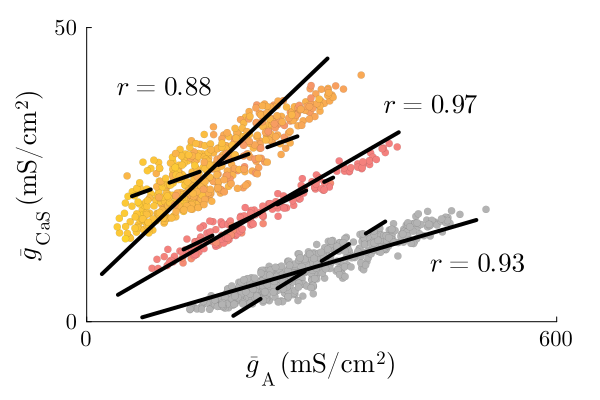

In [25]:
s2 = 2.3
p5b = scatter(g_all_spiking[:, 4], g_all_spiking[:, 3], label="", grid=false, yguidefontsize=18, xguidefontsize=18, 
              margin=5Plots.mm, legend=false, color=:gray70, colorbar_title="burstiness", tickfontsize=15,
              colorbar_titlefontsize=18, markerstrokewidth=0., size=(600, 400), 
              xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]))
scatter!(g_all_doublets_plot[:, 4], g_all_doublets_plot[:, 3], label="", 
         zcolor=burstiness_doublets, c=cgrad(mycmap, rev=false), markerstrokewidth=0.)
scatter!(g_all_bursting[:, 4], g_all_bursting[:, 3], label="", 
         zcolor=burstiness_bursting, c=cgrad(mycmap, rev=false),
         markerstrokewidth=0.)

plot!([mean_spiking[4] - s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[4] + s1*eig_spiking_plot.vectors[:, nb_channels][4]*eig_spiking_plot.values[nb_channels]],
       [mean_spiking[3] - s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels], 
       mean_spiking[3] + s1*eig_spiking_plot.vectors[:, nb_channels][3]*eig_spiking_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_spiking[4] - s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[4] + s2*eig_spiking_plot.vectors[:, nb_channels-1][4]*eig_spiking_plot.values[nb_channels-1]],
       [mean_spiking[3] - s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1], 
       mean_spiking[3] + s2*eig_spiking_plot.vectors[:, nb_channels-1][3]*eig_spiking_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_doublets[4] - s1*eig_doublets_plot.vectors[:, nb_channels][4]*eig_doublets_plot.values[nb_channels], 
       mean_doublets[4] + s1*eig_doublets_plot.vectors[:, nb_channels][4]*eig_doublets_plot.values[nb_channels]],
       [mean_doublets[3] - s1*eig_doublets_plot.vectors[:, nb_channels][3]*eig_doublets_plot.values[nb_channels], 
       mean_doublets[3] + s1*eig_doublets_plot.vectors[:, nb_channels][3]*eig_doublets_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_doublets[4] - s2*eig_doublets_plot.vectors[:, nb_channels-1][4]*eig_doublets_plot.values[nb_channels-1], 
       mean_doublets[4] + s2*eig_doublets_plot.vectors[:, nb_channels-1][4]*eig_doublets_plot.values[nb_channels-1]],
       [mean_doublets[3] - s2*eig_doublets_plot.vectors[:, nb_channels-1][3]*eig_doublets_plot.values[nb_channels-1], 
       mean_doublets[3] + s2*eig_doublets_plot.vectors[:, nb_channels-1][3]*eig_doublets_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

plot!([mean_bursting[4] - s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[4] + s1*eig_bursting_plot.vectors[:, nb_channels][4]*eig_bursting_plot.values[nb_channels]],
       [mean_bursting[3] - s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels], 
       mean_bursting[3] + s1*eig_bursting_plot.vectors[:, nb_channels][3]*eig_bursting_plot.values[nb_channels]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:solid)

plot!([mean_bursting[4] - s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[4] + s2*eig_bursting_plot.vectors[:, nb_channels-1][4]*eig_bursting_plot.values[nb_channels-1]],
       [mean_bursting[3] - s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1], 
       mean_bursting[3] + s2*eig_bursting_plot.vectors[:, nb_channels-1][3]*eig_bursting_plot.values[nb_channels-1]],
       arrow=false, color=:black, linewidth=4, label="", linestyle=:dash)

pearson_cor_spiking = cor(g_all_spiking[:, 3], g_all_spiking[:, 4])
str_pearson_cor_spiking = @sprintf "%.2f" pearson_cor_spiking
annotate!(500, 10, Plots.text(L"r =  %$str_pearson_cor_spiking", :black, :center, 18))

pearson_cor_doublets = cor(g_all_doublets[:, 3], g_all_doublets[:, 4])
str_pearson_cor_doublets = @sprintf "%.2f" pearson_cor_doublets
annotate!(440, 37, Plots.text(L"r =  %$str_pearson_cor_doublets", :black, :center, 18))

pearson_cor_bursting = cor(g_all_bursting[:, 3], g_all_bursting[:, 4])
str_pearson_cor_bursting = @sprintf "%.2f" pearson_cor_bursting
annotate!(100, 40, Plots.text(L"r =  %$str_pearson_cor_bursting", :black, :center, 18))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p5b)
# savefig(p5b, "./figures/PCA_STG_neuromod_gCaSA_burstiness.pdf")

In [26]:
# Initializing a flag
flag_start = true

# Removing unsuccessful simulations
for i = 1 : ncells
    if !isnan.(burstiness_doublets_DIC_plot)[i]
        if flag_start
            # Creating the conductance matrix
            global g_all_doublets_DIC_plot = g_all_doublets_DIC[i, :]
            flag_start = false
        else
            # Adding a line to the conductance matrix
            g_all_doublets_DIC_plot = hcat(g_all_doublets_DIC_plot, g_all_doublets_DIC[i, :])
        end
    end
end

# Transposing the conductance matrix
if @isdefined g_all_doublets_DIC_plot
    g_all_doublets_DIC_plot = g_all_doublets_DIC_plot'
end;

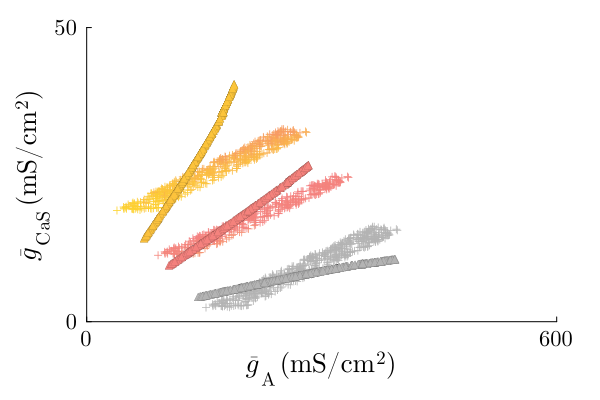

In [33]:
p5c = scatter(g_all_spiking_DIC[:, 4], g_all_spiking_DIC[:, 3], label="", legend=false,
              markershape=:cross, color=:gray70, grid=false, yguidefontsize=18, 
              xguidefontsize=18, legendfontsize=12, margin=5Plots.mm, tickfontsize=15,
              colorbar_titlefontsize=18, size=(600, 400), 
              xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]),
              colorbar_title="burstiness")
scatter!(g_all_spiking_leak[:, 4], g_all_spiking_leak[:, 3], label="", 
         color=:gray70, markershape=:utriangle, markerstrokewidth=0.)
scatter!(g_all_doublets_DIC_plot[:, 4], g_all_doublets_DIC_plot[:, 3], label="", markershape=:cross,
         zcolor=burstiness_doublets_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_doublets_leak[:, 4], g_all_doublets_leak[:, 3], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_doublets_leak, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_DIC[:, 4], g_all_bursting_DIC[:, 3], label="",
         markershape=:cross, zcolor=burstiness_bursting_DIC, c=cgrad(mycmap, rev=false))
scatter!(g_all_bursting_leak[:, 4], g_all_bursting_leak[:, 3], label="", markerstrokewidth=0.,
         markershape=:utriangle, zcolor=burstiness_bursting_leak, c=cgrad(mycmap, rev=false))

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p5c)
# savefig(p5c, "./figures/neuromod_gCaSA_separation_burstiness.pdf")

# **Plotting neuromodulation paths using DICs method (Figure 6)**

In [34]:
burstiness = readdlm("./data/burstiness_paths.dat")
g_all_init = readdlm("./data/g_all_init_paths.dat")
gCaSs = readdlm("./data/gCaSs_paths.dat")
gAs = readdlm("./data/gAs_paths.dat");

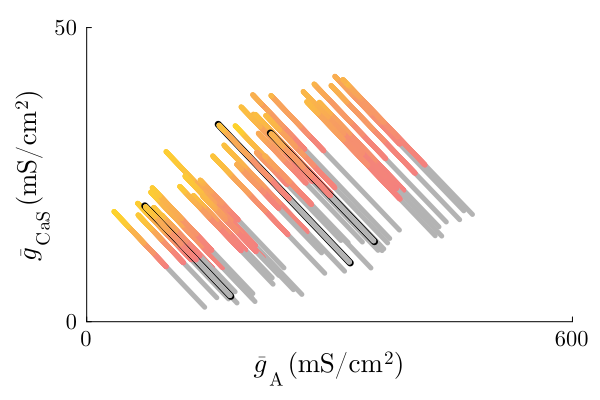

In [37]:
#### Initializing some variables
n = size(gCaSs)[2]

# Picking first path randomly
Random.seed!(2020)
j1 = Int(ceil(rand(1, 1)[1] * n))

# Picking second path randomly
Random.seed!(410)
j2 = Int(ceil(rand(1, 1)[1] * n))

# Picking third path randomly
Random.seed!(809)
j3 = Int(ceil(rand(1, 1)[1] * n))

# Plotting the results
p6a = plot(legend=false, tickfontsize=15, markerstrokewidth=0., size=(600, 400), 
           xticks=([0, 600], [L"0", L"600"]), yticks=([0, 50], [L"0", L"50"]))

# Looping over all neurons
for j = 1 : n    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gAs[1:i_thresh, j], gCaSs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gAs[i_thresh:end, j], gCaSs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(700, 7000),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

# Plotting special paths
for j in [j1, j2, j3]
    # Add a black frame to the path
    line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
    start_x = minimum(gAs[:, j]) - 1
    end_x = maximum(gAs[:, j]) + 1
    plot!([start_x, end_x], [line_ACaS(start_x), line_ACaS(end_x)], 
          label="", grid=false, linewidth=7, yguidefontsize=18, 
          xguidefontsize=18, margin=5Plots.mm, color=:black)

    plot!(gAs[:, j], gCaSs[:, j], label="", grid=false, linewidth=5, 
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:white)
    
    # Plotting first spiking neurons
    i_thresh = minimum(findall(burstiness[:, j] .> 0))
    if i_thresh > 1
        plot!(gAs[1:i_thresh, j], gCaSs[1:i_thresh, j], label="", grid=false, linewidth=5, 
              yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, color=:gray70)
    end
    
    # Then plotting bursting neurons
    plot!(gAs[i_thresh:end, j], gCaSs[i_thresh:end, j], label="", 
          line_z=burstiness[i_thresh:end, j], grid=false, linewidth=5, clim=(700, 7000),
          yguidefontsize=18, xguidefontsize=18, margin=5Plots.mm, c=cgrad(mycmap, rev=false))
end

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 600))
display(p6a)
# savefig(p6a, "./figures/neuromod_gCaSA_paths.pdf")

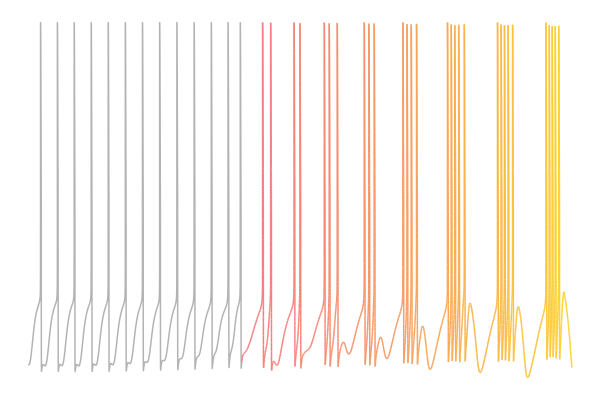

In [77]:
# Definition of simulation time (in ms)
const Tfinal = 2015
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(2020)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1090:end]
t = sol.t[1090:end]
p6b = plot(t[1:2110], V_t[1:2110], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[2110:end], V_t[2110:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[2110:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6b)
savefig(p6b, "./figures/neuromod_gCaSA_path_simu1.pdf")

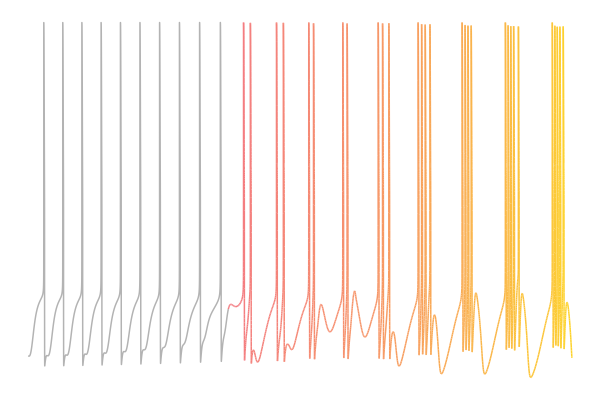

In [78]:
# Definition of simulation time (in ms)
const Tfinal = 2050
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(410)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1130:end]
t = sol.t[1130:end]
p6c = plot(t[1:1700], V_t[1:1700], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[1700:end], V_t[1700:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[1700:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6c)
savefig(p6c, "./figures/neuromod_gCaSA_path_simu2.pdf")

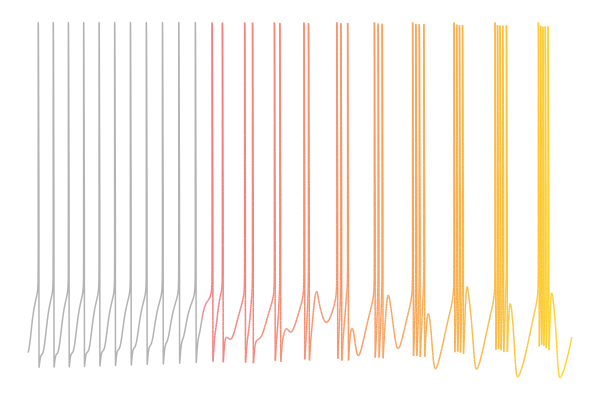

In [79]:
# Definition of simulation time (in ms)
const Tfinal = 2080
const tspan  = (0.0, Tfinal)

# Fixing random seed
Random.seed!(809)

# Retrieving maximal conductances from what had been computed
j = Int(ceil(rand(1, 1)[1] * n))

include("FYON_2022_STG_models.jl") # Loading of STG model

# Computing the regression line along the neuromodulation path
line_ACaS = fit(gAs[:, j], gCaSs[:, j], 1)
a0 = line_ACaS[0]
a1 = line_ACaS[1]
gA_min = minimum(gAs[:, j])
gA_max = maximum(gAs[:, j])

# Extracting the maximal ion channel conductances
(gNa, gCaT, _, _, gKCa, gKd, gH, gleak) = g_all_init[j, :]

# Parameter vector for simulations
p = [0., gNa, gCaT, gA_min, gA_max, gKCa, gKd, gH, gleak, C, a0, a1]

# Initial conditions
V0  = -70.
Ca0 = 0.5
x0  = [V0, mNa_inf(V0), hNa_inf(V0), mCaT_inf(V0), hCaT_inf(V0), mCaS_inf(V0), 
      hCaS_inf(V0), mA_inf(V0), hA_inf(V0), mKCa_inf(V0, Ca0), mKd_inf(V0), mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(STG_ODE_neuromod, x0, tspan, p)
sol = solve(prob, verbose=false)

# Removing transient part
V_t = sol[1, :][1080:end]
t = sol.t[1080:end]
p6d = plot(t[1:1765], V_t[1:1765], linewidth=1.5, grid=false, xticks=[], yticks=[], color=:gray70, 
           yguidefontsize=18, xguidefontsize=18, legend=false, axis=false)
plot!(t[1765:end], V_t[1765:end], linewidth=1.5, grid=false, xticks=[], yticks=[], 
      line_z=range(0, 7000, length(t[1765:end])), c=cgrad(mycmap, rev=false), yguidefontsize=18, 
      xguidefontsize=18, legend=false, axis=false)
display(p6d)
savefig(p6d, "./figures/neuromod_gCaSA_path_simu3.pdf")

# **Computing PCA on homogeneous scaled neurons using Monte Carlo (Figure supp 1)**

In [80]:
g_all_MC_leak = readdlm("./data/g_all_MC_leak.dat")
f_leak = readdlm("./data/f_leak.dat")
Iapp = readdlm("./data/Iapp.dat")
rheobase = readdlm("./data/rheobase.dat")

# Definition of the number of cells in the random set
const ncells = 200;

In [81]:
# Number of ion channels in the STG model
nb_channels = 8

# Means on spiking point cloud
mean_MC_leak = zeros(1, nb_channels)
mean!(mean_MC_leak, g_all_MC_leak)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

# Normalizing data before applying PCA
g_all_MC_leak_norm = deepcopy(g_all_MC_leak)
for i = 1 : nb_channels
    g_all_MC_leak_norm[:, i] = g_all_MC_leak[:, i] / std(g_all_MC_leak[:, i])
end

# PCA on spiking point cloud
cov_matrix_MC_leak = cov(g_all_MC_leak_norm)
eig_MC_leak = eigen(cov_matrix_MC_leak, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_MC_leak_plot = deepcopy(eig_MC_leak)
for i = 1 : nb_channels
    eig_MC_leak_plot.vectors[i, :] = eig_MC_leak_plot.vectors[i, :] * std(g_all_MC_leak[:, i])
end

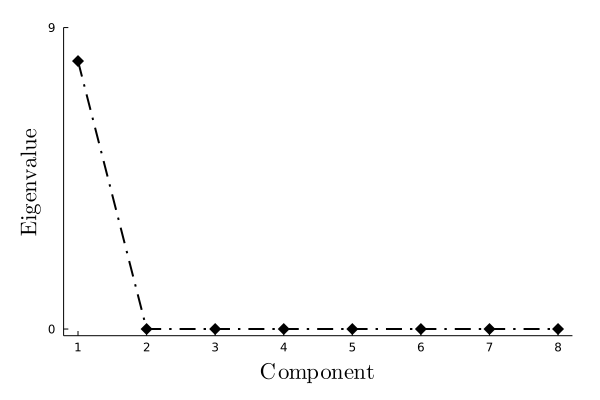

In [82]:
total_var = sum(eig_MC_leak.values)
eig_val_decreasing = reverse(eig_MC_leak.values)
ps1a = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6, 7, 8], color=:black, markersize=6, linewidth=2, yticks=[0, 9])
ylims!((-0.2, 9))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps1a)
savefig(ps1a, "./figures/STG_MC_scree_leak.pdf")

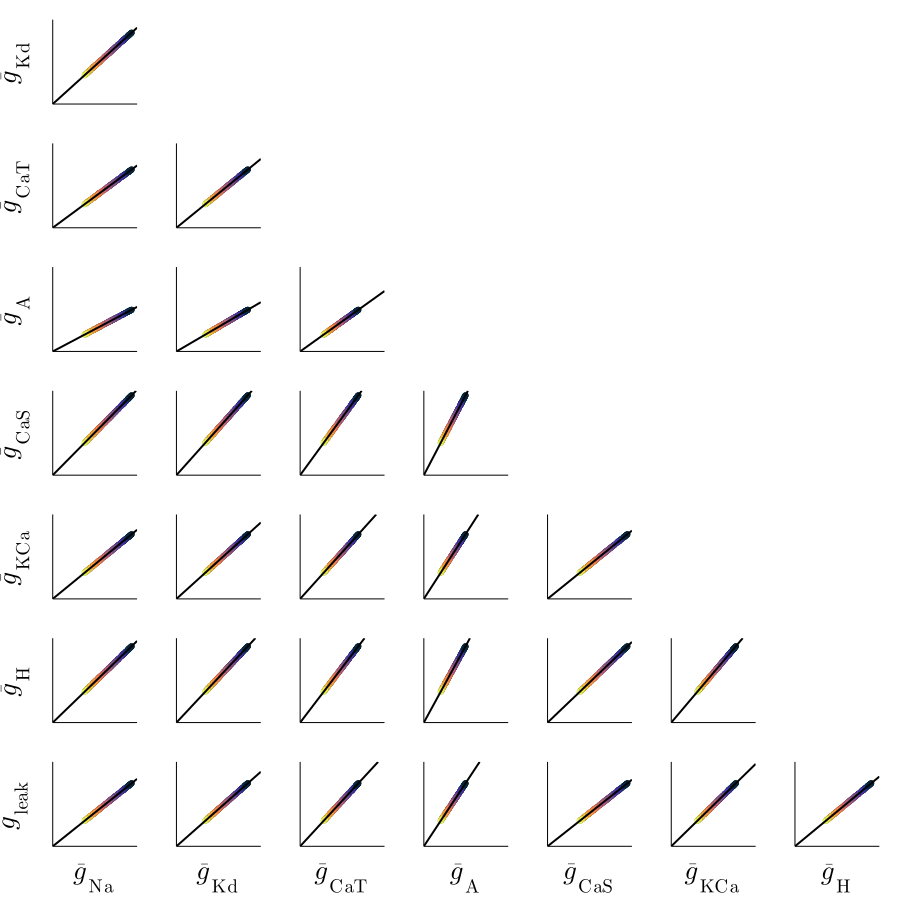

In [83]:
CCs1 = scatter_matrix_zcolor(eig_MC_leak_plot, nb_channels, g_all_MC_leak, mean_MC, Na_max*1.1, CaT_max,
                             CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max, s1*2, 0, rheobase, :none)
display(CCs1)
savefig(CCs1, "./figures/STG_MC_matrix_leak.pdf")

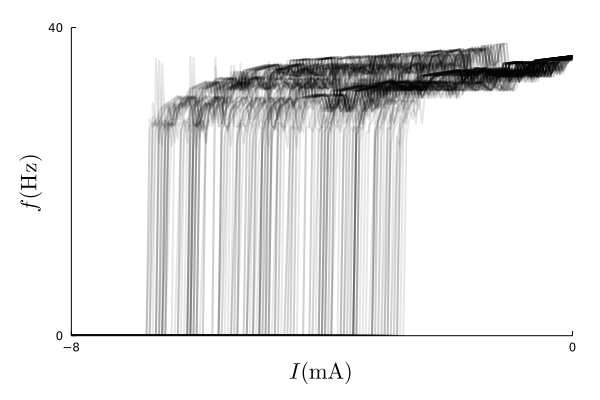

In [84]:
# Initializing some variables
f_leak_plot = deepcopy(f_leak)

# Plotting the I f curves
ps1b = plot()
for i = 1 : ncells
    # Removing local overshoots when releasing
    index = findall(f_leak_plot[:, i] .> 40.)
    for ii in index
        f_leak_plot[ii, i] = (f_leak_plot[ii-1, i] + f_leak_plot[ii+1, i])/2
    end
    
    plot!(Iapp, f_leak_plot[:, i], label="", grid=false, yguidefontsize=15, xguidefontsize=15, 
          legendfontsize=12, margin=5Plots.mm, color=:black, alpha=0.1, linewidth=2, 
          xticks=[-8, 0], yticks=[0, 40])
end
xlabel!(L"I\,\mathrm{(mA)}")
ylabel!(L"f\,\mathrm{(Hz)}")
xlims!((-8, 0))
ylims!((0, 40))
display(ps1b)
savefig(ps1b, "./figures/simu_STG_MC_hyper_leak.pdf")

# **Plotting high frequency bursting neurons generated using the DICs method (Figure supp 2)**

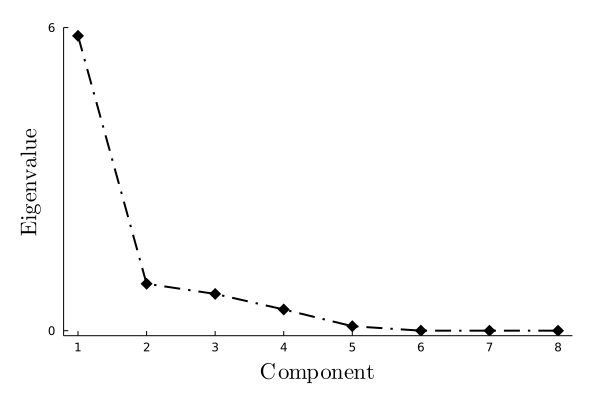

In [85]:
total_var = sum(eig_bursting.values)
eig_val_decreasing = reverse(eig_bursting.values)

ps2 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6, 7, 8], color=:black, markersize=6, linewidth=2, yticks=[0, 6])
ylims!((-0.1, 6))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps2)
savefig(ps2, "./figures/STG_PCA_bursting_scree.pdf")

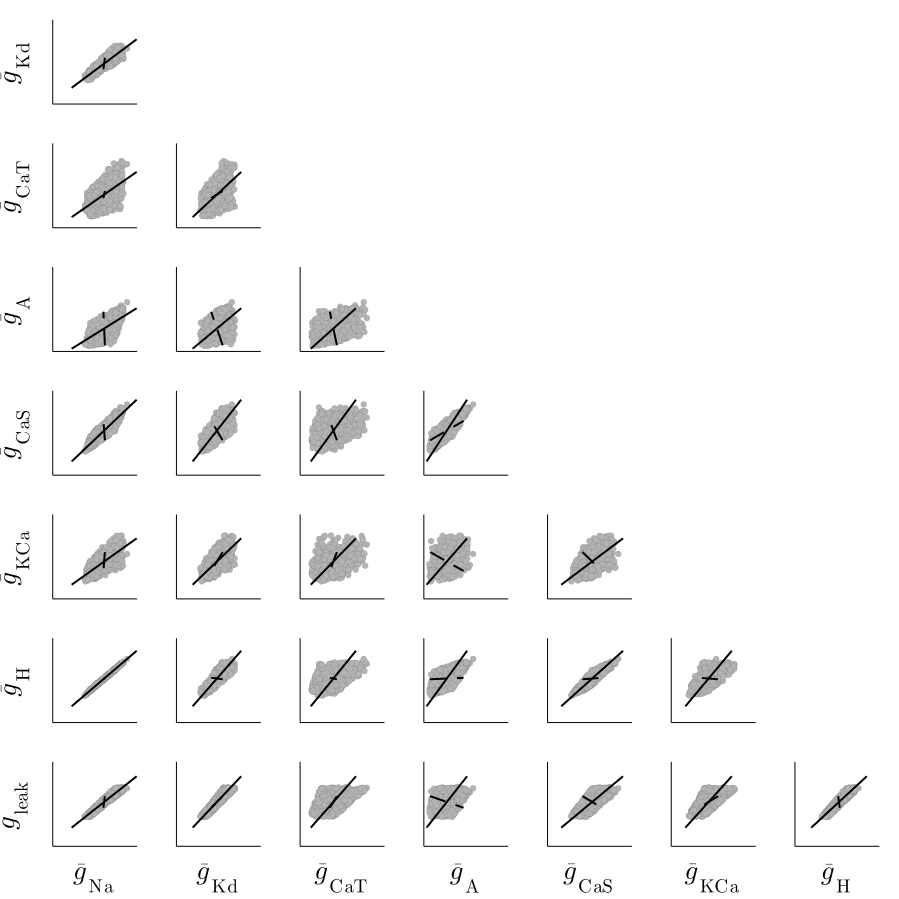

In [86]:
CCs2 = scatter_matrix(eig_bursting_plot, nb_channels, g_all_bursting, mean_bursting, Na_max, CaT_max,
                     CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max, s1, s2*2, :gray70, :none)
display(CCs2)
savefig(CCs2, "./figures/STG_PCA_bursting_matrix.pdf")

# **Computing PCA on high frequency bursting neurons generated using the DICs method, property separated (Figure supp 3&4)**

In [87]:
# Definition of the number of cells in the random set
const ncells = 500;

In [88]:
# Means on bursting point cloud
mean_bursting_leak = zeros(1, nb_channels)
mean!(mean_bursting_leak, g_all_bursting_leak)

# Defining scaling factors and limits for the plots
s1 = 1.3
s2 = 1.3
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

# Normalizing data before applying PCA
g_all_bursting_leak_norm = deepcopy(g_all_bursting_leak)
for i = 1 : nb_channels
    g_all_bursting_leak_norm[:, i] = g_all_bursting_leak[:, i] / std(g_all_bursting_leak[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting_leak = cov(g_all_bursting_leak_norm)
eig_bursting_leak = eigen(cov_matrix_bursting_leak, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_leak_plot = deepcopy(eig_bursting_leak)
for i = 1 : nb_channels
    eig_bursting_leak_plot.vectors[i, :] = eig_bursting_leak_plot.vectors[i, :] * std(g_all_bursting_leak[:, i])
end

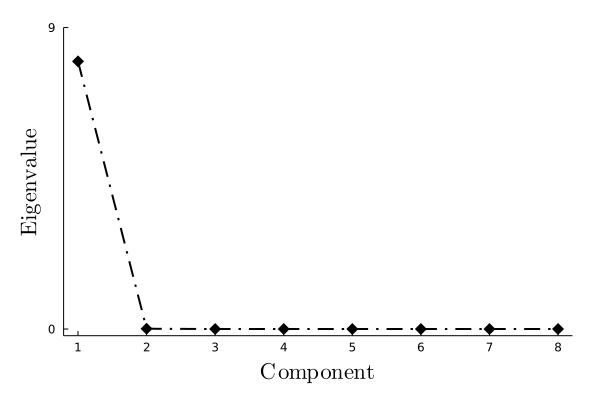

In [89]:
total_var = sum(eig_bursting_leak.values)
eig_val_decreasing = reverse(eig_bursting_leak.values)
ps3 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6, 7, 8], color=:black, markersize=6, linewidth=2, yticks=[0, 9])
ylims!((-0.2, 9))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps3)
savefig(ps3, "./figures/STG_PCA_bursting_scree_leak.pdf")

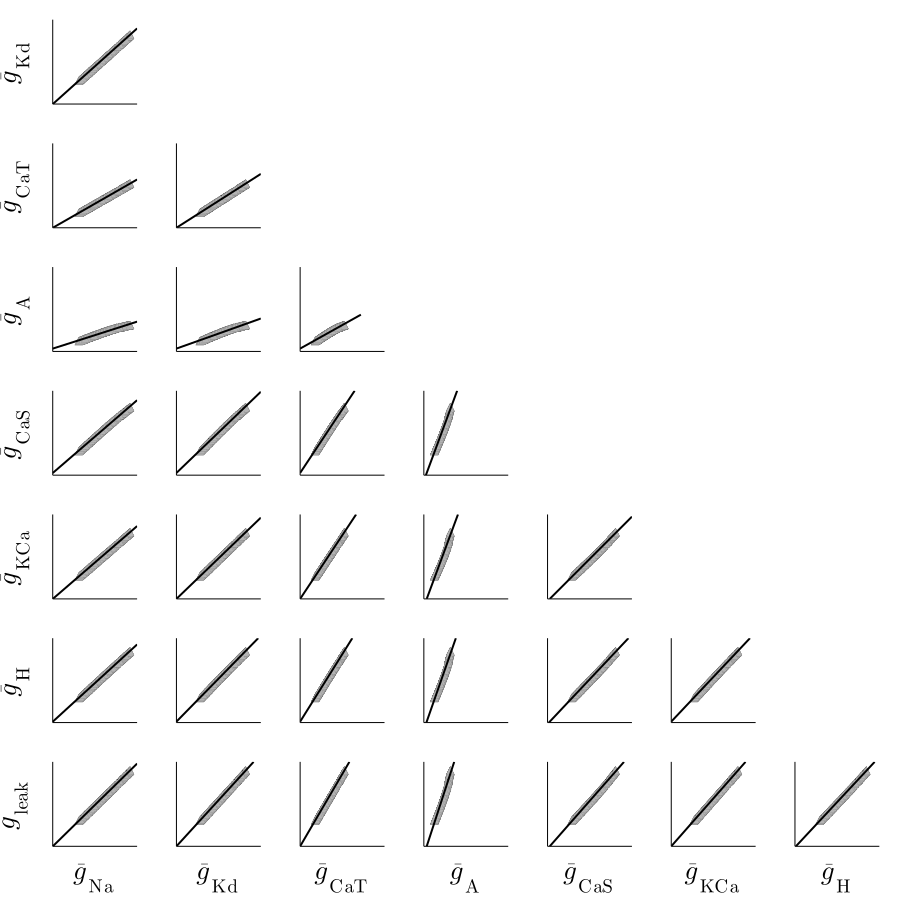

In [90]:
CCs3 = scatter_matrix(eig_bursting_leak_plot, nb_channels, g_all_bursting_leak, mean_bursting_leak, 
                      Na_max*1.1, CaT_max, CaS_max, A_max, KCa_max, Kd_max, H_max, leak_max, s1, 0, 
                      :gray70, :utriangle)
display(CCs3)
savefig(CCs3, "./figures/STG_PCA_bursting_leak_matrix.pdf")

In [91]:
# Means on bursting point cloud
mean_bursting_DIC = zeros(1, nb_channels)
mean!(mean_bursting_DIC, g_all_bursting_DIC)

# Defining scaling factors and limits for the plots
s1 = 1.5
s2 = 1.5
Na_max = 8000
CaT_max = 12
CaS_max = 50
A_max = 600
KCa_max = 250
Kd_max = 350
H_max = 0.7
leak_max = 0.02

# Normalizing data before applying PCA
g_all_bursting_DIC_norm = deepcopy(g_all_bursting_DIC)
for i = 1 : nb_channels-1
    g_all_bursting_DIC_norm[:, i] = g_all_bursting_DIC[:, i] / std(g_all_bursting_DIC[:, i])
end

# PCA on spiking point cloud
cov_matrix_bursting_DIC = cov(g_all_bursting_DIC_norm)
eig_bursting_DIC = eigen(cov_matrix_bursting_DIC, sortby = x -> abs(x))

# Computing PCA components to map back to the non-normalized dataset
eig_bursting_DIC_plot = deepcopy(eig_bursting_DIC)
for i = 1 : nb_channels
    eig_bursting_DIC_plot.vectors[i, :] = eig_bursting_DIC_plot.vectors[i, :] * std(g_all_bursting_DIC[:, i])
end

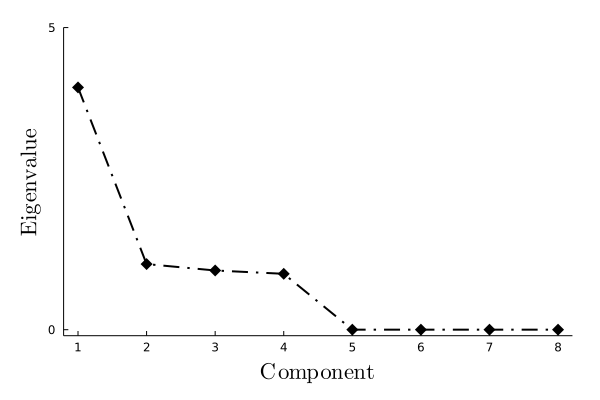

In [92]:
total_var = sum(eig_bursting_DIC.values)
eig_val_decreasing = reverse(eig_bursting_DIC.values)
ps4 = plot(eig_val_decreasing, label="", grid=false, yguidefontsize=15, markershape=:diamond, 
           linestyle=:dashdot, xguidefontsize=15, legendfontsize=12, margin=5Plots.mm, 
           xticks=[1, 2, 3, 4, 5, 6, 7, 8], color=:black, markersize=6, linewidth=2, yticks=[0, 5])
ylims!((-0.1, 5))
xlabel!(L"\mathrm{Component}")
ylabel!(L"\mathrm{Eigenvalue}")
display(ps4)
savefig(ps4, "./figures/STG_PCA_bursting_scree_DIC.pdf")

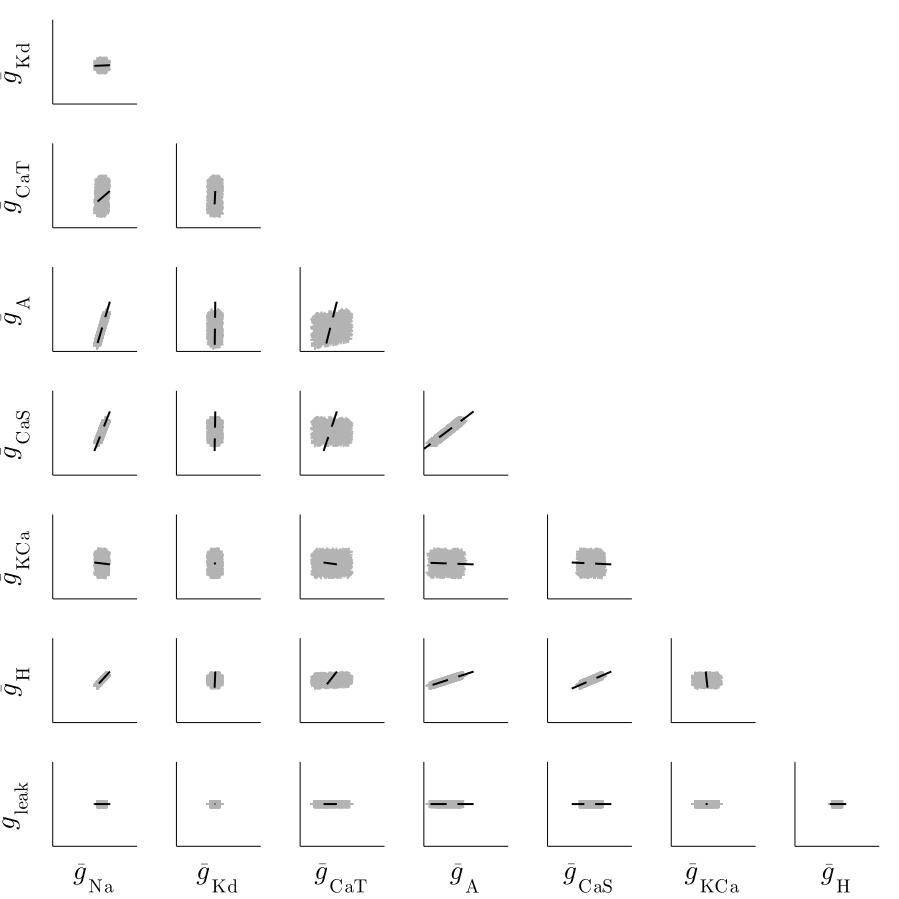

In [93]:
eig_bursting_DIC_plot.vectors[:, nb_channels-1] = eig_bursting_DIC_plot.vectors[:, nb_channels]
eig_bursting_DIC_plot.values[nb_channels-1]=eig_bursting_DIC_plot.values[nb_channels]
CCs4 = scatter_matrix(eig_bursting_DIC_plot, nb_channels, g_all_bursting_DIC, 
                      mean_bursting_DIC, Na_max, CaT_max, CaS_max, A_max, KCa_max, Kd_max, 
                      H_max, leak_max, 0, s2, :gray70, :cross)
display(CCs4)
savefig(CCs4, "./figures/STG_PCA_bursting_DIC_matrix.pdf")

# **Plotting high frequency bursting neurons generated using the DICs method and highlighting Rin (Figure supp 5)**

In [94]:
# Defining threshold voltage
Vth = -50.

# Definition of the number of cells in the random set
const ncells = 2000;

In [95]:
# Initializing some variables
Rin_bursting_many = zeros(ncells)

# Looping over all points to compute input resistance at threshold voltage
for i = 1 : ncells
    Ca_th = -0.94*(g_all_bursting_many[i, 2]*mCaT_inf(Vth)^3*hCaT_inf(Vth)*(Vth-VCa) + 
                   g_all_bursting_many[i, 3]*mCaS_inf(Vth)^3*hCaS_inf(Vth)*(Vth-VCa)) + 0.05
    Rin_bursting_many[i] = (g_all_bursting_many[i, 1]*mNa_inf(Vth)^3*hNa_inf(Vth) + 
                            g_all_bursting_many[i, 2]*mCaT_inf(Vth)^3*hCaT_inf(Vth) + 
                            g_all_bursting_many[i, 3]*mCaS_inf(Vth)^3*hCaS_inf(Vth) + 
                            g_all_bursting_many[i, 4]*mA_inf(Vth)^3*hA_inf(Vth) +
                            g_all_bursting_many[i, 5]*mKCa_inf(Vth, Ca_th)^4 +
                            g_all_bursting_many[i, 6]*mKd_inf(Vth)^4 +
                            g_all_bursting_many[i, 7]*mH_inf(Vth) + 
                            g_all_bursting_many[i, 8])^(-1)
end

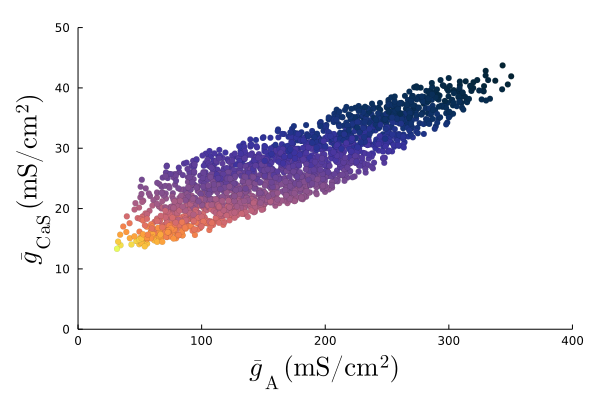

In [96]:
ps5 = scatter(g_all_bursting_many[:, 4], g_all_bursting_many[:, 3], label="", 
              zcolor=Rin_bursting_many, grid=false, yguidefontsize=18, xguidefontsize=18, 
              legendfontsize=12, margin=5Plots.mm, c=cgrad(:thermal, rev=false), legend=false, 
              markerstrokewidth=0.)

ylabel!(L"\bar{g}_\mathrm{CaS}\,\mathrm{(mS/cm^2)}")
xlabel!(L"\bar{g}_\mathrm{A}\,\mathrm{(mS/cm^2)}")
ylims!((0, 50))
xlims!((0, 400))
display(ps5)
savefig(ps5, "./figures/neuromod_many_gCaSA_zRin_bursting.pdf")